# 🎬Decoding IMDb Success: A Full-Scale Predictive Content Intelligence Analysis

## Introduction

In today’s streaming-first world, success on platforms like Netflix, Prime Video, Disney+, and Hulu is shaped by far more than audience preferences—
it is driven by measurable, predictable patterns hidden within the content itself.

Using a unified multi-platform dataset enriched with IMDb intelligence, we built an end-to-end predictive framework to uncover what truly determines a movie or TV show's rating—and more importantly, why certain titles thrive while others fade.

**🚀This analysis brings together:**

*   Advanced feature engineering
*   Machine learning modeling
*   Text mining (TF-IDF)
*   Genre, platform, region, and duration analytics

to reveal the five key factors that shape rating outcomes—ranked by impact on the final model.

**🎯 The result?**

A content intelligence system that not only predicts performance—but explains the DNA of streaming hits.

From description quality to genre blends, platform strategies, regional strengths, and optimal content length…
we break down exactly what makes audiences rate a title highly.

Let's dive into it!

# Setup & Data Loading

Install and import all required libraries for analysis, visualizations, and machine learning.

Allow CSV upload from your local computer using files.upload().

Load the four OTT datasets (Netflix, Prime Video, Disney+, Hulu) into pandas.


In [ ]:
# ============================================================
# 0. SETUP & DATA LOADING
# ============================================================

!pip install prophet --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_squared_error, r2_score,
    accuracy_score, classification_report,confusion_matrix, roc_curve, auc
)


from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from prophet import Prophet

from sklearn.ensemble import (
    RandomForestRegressor,
    RandomForestClassifier,
    GradientBoostingClassifier
)


sns.set(style="whitegrid")
plt.style.use("default")
pd.set_option("display.max_columns", 100)



Loading the Datasets for Analysis

In [ ]:


netflix = pd.read_csv("netflix_titles.csv")
prime   = pd.read_csv("amazon_prime_titles.csv")
disney  = pd.read_csv("disney_plus_titles.csv")
hulu    = pd.read_csv("hulu_titles.csv")

print("Netflix:", netflix.shape)
print("Prime  :", prime.shape)
print("Disney :", disney.shape)
print("Hulu   :", hulu.shape)

Netflix: (8807, 12)
Prime  : (9668, 12)
Disney : (1450, 12)
Hulu   : (3073, 12)


# Standardizing & Combining OTT Datasets

Clean and standardize column names across all four OTT datasets.



Add a platform column to identify which service each title belongs to.

Normalize column names so different files follow the same structure.

Keep only the relevant fields (title, type, genres, year, rating, etc.).

Combine Netflix, Prime Video, Disney+, and Hulu into one unified dataframe (ott).



In [ ]:
# ------------------------------------------------------------
# 0.2 Standardize columns & build unified OTT dataframe
# ------------------------------------------------------------

for df, plat in [(netflix, "Netflix"),
                 (prime, "Prime Video"),
                 (disney, "Disney+"),
                 (hulu, "Hulu")]:
    df.columns = df.columns.str.lower().str.strip().str.replace(" ", "_")
    df["platform"] = plat

# Some files use slightly different column sets. Normalize them.
def normalize_ott(df):
    df = df.rename(columns={
        "listed_in": "genres",
        "release_year": "release_year",
        "rating": "rating",
        "duration": "duration",
        "description": "description",
    })
    keep = ["title", "type", "genres", "release_year",
            "rating", "duration", "description", "platform", "date_added", "country"]
    # keep only existing columns
    keep = [c for c in keep if c in df.columns]
    return df[keep]

netflix = normalize_ott(netflix)
prime   = normalize_ott(prime)
disney  = normalize_ott(disney)
hulu    = normalize_ott(hulu)

ott = pd.concat([netflix, prime, disney, hulu], ignore_index=True)
print("Unified OTT shape:", ott.shape)
ott.head()

Unified OTT shape: (22998, 10)


,title,type,genres,release_year,rating,duration,description,platform,date_added,country
0,Dick Johnson Is Dead,Movie,Documentaries,2020,PG-13,90 min,"As her father nears the end of his life, filmm...",Netflix,"September 25, 2021",United States
1,Blood & Water,TV Show,"International TV Shows, TV Dramas, TV Mysteries",2021,TV-MA,2 Seasons,"After crossing paths at a party, a Cape Town t...",Netflix,"September 24, 2021",South Africa
2,Ganglands,TV Show,"Crime TV Shows, International TV Shows, TV Act...",2021,TV-MA,1 Season,To protect his family from a powerful drug lor...,Netflix,"September 24, 2021",NaN
3,Jailbirds New Orleans,TV Show,"Docuseries, Reality TV",2021,TV-MA,1 Season,"Feuds, flirtations and toilet talk go down amo...",Netflix,"September 24, 2021",NaN
4,Kota Factory,TV Show,"International TV Shows, Romantic TV Shows, TV ...",2021,TV-MA,2 Seasons,In a city of coaching centers known to train I...,Netflix,"September 24, 2021",India


# Enrich OTT Data with IMDb Ratings

Upload IMDb files: **title.basics.tsv** and **title.ratings.tsv.**

Filter IMDb to only movies, TV series, and mini-series.

Merge IMDb basics + ratings into one dataset.

Clean key numeric fields: averageRating, numVotes, startYear.

Create a helper title column (title_clean) in both IMDb and OTT data for matching.

Join OTT titles with IMDb using this cleaned title.

Add IMDb fields (rating, votes, genres, year) onto the unified OTT dataset.

In [ ]:
# ------------------------------------------------------------
# 0.5 IMDb data & join with OTT for ratings-based analyses
# ------------------------------------------------------------


imdb_basics  = pd.read_csv("title.basics.tsv",  sep="\t", low_memory=False)
imdb_ratings = pd.read_csv("title.ratings.tsv", sep="\t", low_memory=False)

# Keep only movies / TV series / mini-series
imdb_basics = imdb_basics[
    imdb_basics["titleType"].isin(["tvSeries", "movie", "tvMiniSeries"])
]

# Merge basics + ratings
imdb = imdb_basics.merge(imdb_ratings, on="tconst", how="inner")

# Clean numeric fields
imdb["averageRating"] = pd.to_numeric(imdb["averageRating"], errors="coerce")
imdb["numVotes"]      = pd.to_numeric(imdb["numVotes"], errors="coerce")
imdb["startYear"]     = pd.to_numeric(imdb["startYear"], errors="coerce")

# Helper title column (lowercased/stripped) for matching
imdb["title_clean"] = imdb["primaryTitle"].str.lower().str.strip()

# Clean title in OTT & create same helper column
ott["title_clean"] = ott["title"].str.lower().str.strip()

# Prepare a subset of IMDb columns (rename to avoid 'genres' clash)
imdb_subset = imdb[[
    "tconst",
    "title_clean",
    "averageRating",
    "numVotes",
    "genres",
    "startYear"
]].rename(columns={
    "genres": "genres_imdb",
    "startYear": "startYear_imdb"
})

# Merge OTT + IMDb on cleaned title
ott_imdb = ott.merge(
    imdb_subset,
    on="title_clean",
    how="left"
)

print("Unified OTT shape (before IMDb merge):", ott.shape)
print("OTT rows with IMDb match:", ott_imdb["tconst"].notna().sum())
print("Final OTT+IMDb shape:", ott_imdb.shape)

ott_imdb.head()


NameError: name 'pd' is not defined

# Wikipedia-Based Region Enrichment for OTT Dataset

This code automatically fills missing or incorrect region values in the OTT dataset by searching Wikipedia pages for each movie or series, extracting the country of origin, and mapping it to a global region (Asia, Europe, North America, etc.). It works only on rows where region is "Unknown" or "Other" to avoid overwriting correct values.


The code checks which OTT titles have region = "Unknown" or "Other".

For each such title, builds possible Wikipedia title variations (e.g., Movie, Film, TV Series).

Searches Wikipedia for the correct page using the API.

Extracts the country of origin from the page’s infobox.

Maps the extracted country to a region (Asia, Europe, North America, etc.).

Updates the OTT dataset with this newly found region.


In [ ]:
import pandas as pd
import requests
import re
import time
import json

# =========================
# CONFIG
# =========================
WIKI_API = "https://en.wikipedia.org/w/api.php"
REQUEST_DELAY = 0.3       # be gentle with Wikipedia
MAX_CALLS = 600           # safety cap

# Wikipedia asks for a descriptive User-Agent
HEADERS = {
    "User-Agent": "StreamingRegionCleaner/1.0 (contact: your_email@example.com)"
}

# =========================
# REGION MAPPING (same as earlier)
# =========================
def country_to_region(country_name):
    if not isinstance(country_name, str) or not country_name.strip():
        return "Other"

    c = country_name.strip().lower()

    north_america = {
        "usa", "united states", "united states of america",
        "canada", "mexico"
    }

    europe = {
        "uk", "united kingdom", "england", "scotland", "wales", "ireland",
        "france", "germany", "italy", "spain", "portugal", "sweden", "norway",
        "denmark", "finland", "iceland", "netherlands", "belgium", "switzerland",
        "austria", "czech republic", "poland", "hungary", "greece", "romania",
        "serbia", "croatia", "slovakia", "slovenia", "bulgaria", "estonia",
        "latvia", "lithuania", "ukraine", "russia", "turkey", "turkiye"
    }

    asia = {
        "india", "china", "japan", "south korea", "korea", "north korea",
        "thailand", "vietnam", "indonesia", "malaysia", "singapore",
        "philippines", "pakistan", "bangladesh", "sri lanka", "nepal",
        "hong kong", "taiwan"
    }

    oceania = {"australia", "new zealand"}

    africa = {
        "south africa", "nigeria", "kenya", "egypt", "morocco", "ghana",
        "ethiopia", "tanzania", "algeria", "tunisia"
    }

    south_america = {
        "brazil", "argentina", "chile", "peru", "colombia", "uruguay",
        "paraguay", "venezuela", "bolivia", "ecuador"
    }

    middle_east = {
        "united arab emirates", "uae", "saudi arabia", "qatar", "kuwait",
        "bahrain", "oman", "iran", "iraq", "israel", "jordan", "lebanon",
        "syria", "yemen", "palestine"
    }

    if c in north_america:
        return "North America"
    if c in europe:
        return "Europe"
    if c in asia:
        return "Asia"
    if c in oceania:
        return "Oceania"
    if c in africa:
        return "Africa"
    if c in south_america:
        return "South America"
    if c in middle_east:
        return "Middle East"
    return "Other"


def map_countries_to_region(country_field: str) -> str:
    if not isinstance(country_field, str) or not country_field.strip():
        return "Other"

    parts = [p.strip() for p in re.split(r"[,/]", country_field) if p.strip()]
    if not parts:
        return "Other"

    # North America priority
    for p in parts:
        if country_to_region(p) == "North America":
            return "North America"

    # Otherwise first listed
    return country_to_region(parts[0])


# =========================
# WIKI TITLE CANDIDATES (no title normalization)
# =========================
def guess_wiki_title(title: str, content_type: str) -> list:
    if not isinstance(title, str):
        return []

    candidates = [title]

    if isinstance(content_type, str):
        ct = content_type.lower().strip()
        if ct in ["tv show", "series", "tv series"]:
            candidates.append(f"{title} (TV series)")
        elif ct in ["movie", "film"]:
            candidates.append(f"{title} (film)")

    seen = set()
    ordered = []
    for c in candidates:
        if c not in seen:
            seen.add(c)
            ordered.append(c)
    return ordered


# =========================
# WIKIPEDIA API HELPERS
# =========================
def safe_json(resp):
    """Try to parse JSON; if it fails, log and return None."""
    try:
        return resp.json()
    except json.JSONDecodeError:
        print(f"Non-JSON response from Wikipedia (status {resp.status_code}): first 200 chars:\n{resp.text[:200]}")
        return None


def wiki_search_title(query: str):
    params = {
        "action": "query",
        "list": "search",
        "srsearch": query,
        "format": "json",
        "srlimit": 1,
    }
    try:
        resp = requests.get(WIKI_API, params=params, headers=HEADERS, timeout=10)
        data = safe_json(resp)
        if not data:
            return None
        hits = data.get("query", {}).get("search", [])
        if hits:
            return hits[0]["title"]
        return None
    except Exception as e:
        print(f"Wiki search error for '{query}': {e}")
        return None


def wiki_get_page_wikitext(title: str):
    params = {
        "action": "query",
        "prop": "revisions",
        "rvprop": "content",
        "rvslots": "main",
        "titles": title,
        "format": "json",
    }
    try:
        resp = requests.get(WIKI_API, params=params, headers=HEADERS, timeout=10)
        data = safe_json(resp)
        if not data:
            return None
        pages = data.get("query", {}).get("pages", {})
        for pageid, page in pages.items():
            revs = page.get("revisions")
            if revs:
                slot = revs[0]
                content = slot.get("*") or slot.get("slots", {}).get("main", {}).get("*")
                return content
        return None
    except Exception as e:
        print(f"Wiki wikitext error for '{title}': {e}")
        return None


def extract_country_from_wikitext(wikitext: str):
    if not isinstance(wikitext, str):
        return None

    m = re.search(r"\|\s*country\s*=\s*(.+)", wikitext, flags=re.IGNORECASE)
    if not m:
        m = re.search(r"\|\s*country\s*of\s*origin\s*=\s*(.+)", wikitext, flags=re.IGNORECASE)
    if not m:
        m = re.search(r"\|\s*origin\s*=\s*(.+)", wikitext, flags=re.IGNORECASE)

    if not m:
        return None

    line = m.group(1)
    line = line.split("\n")[0]
    line = line.split("{{")[0]
    line = line.strip()

    line = re.sub(r"\[\[(.*?)\]\]", r"\1", line)
    line = re.sub(r"<!--.*?-->", "", line)
    line = re.sub(r"\{\{.*?\}\}", "", line)

    return line.strip() or None


# =========================
# MAIN FUNCTION FOR `ott`
# =========================
def enrich_ott_regions_with_wikipedia(ott_df: pd.DataFrame) -> pd.DataFrame:
    """
    Uses Wikipedia to improve 'region' for rows where region is 'Unknown' or 'Other',
    based on (title, type, release_year).
    Updates ott_df in-place and also returns it.
    """

    # Ensure region column exists
    if "region" not in ott_df.columns:
        ott_df["region"] = "Unknown"

    mask_target = ott_df["region"].isin(["Unknown", "Other"])
    print("Rows with region Unknown/Other BEFORE Wikipedia:", mask_target.sum())

    # Only rows needing enrichment
    df_target = ott_df[mask_target].copy()

    # Unique (title, type, release_year)
    key_df = (
        df_target[["title", "type", "release_year"]]
        .drop_duplicates()
    )

    print("Unique (title, type, release_year) combos to query:", len(key_df))

    calls = 0
    key_to_region = {}

    for idx, row in key_df.iterrows():
        if calls >= MAX_CALLS:
            print("Reached MAX_CALLS, stopping Wikipedia calls.")
            break

        title = row["title"]
        content_type = row["type"]
        year = row["release_year"]

        candidates = guess_wiki_title(title, content_type)
        region = None

        for cand in candidates:
            time.sleep(REQUEST_DELAY)
            calls += 1

            page_title = wiki_search_title(cand)
            if not page_title:
                print(f"[WIKI] No search hit for '{cand}'")
                continue

            wikitext = wiki_get_page_wikitext(page_title)
            if not wikitext:
                print(f"[WIKI] No wikitext for page '{page_title}'")
                continue

            country_str = extract_country_from_wikitext(wikitext)
            if country_str:
                region = map_countries_to_region(country_str)
                print(f"[WIKI] '{title}' -> page '{page_title}' -> {country_str} -> {region}")
                break
            else:
                print(f"[WIKI] '{title}' -> page '{page_title}', but no country found")

        if region:
            key_to_region[(title, content_type, year)] = region

    # Apply mapping back to ott_df
    def fill_region_from_wiki(row):
        if row["region"] not in ["Unknown", "Other"]:
            return row["region"]
        key = (row["title"], row["type"], row["release_year"])
        return key_to_region.get(key, row["region"])

    ott_df["region"] = ott_df.apply(fill_region_from_wiki, axis=1)

    mask_after = ott_df["region"].isin(["Unknown", "Other"])
    print("Rows with region Unknown/Other AFTER Wikipedia:", mask_after.sum())
    print("Final region distribution:")
    print(ott_df["region"].value_counts())

    return ott_df


# =========================
# RUN ON YOUR `ott` DATAFRAME
# =========================
ott = enrich_ott_regions_with_wikipedia(ott)


Rows with region Unknown/Other BEFORE Wikipedia: 11517
Unique (title, type, release_year) combos to query: 11480
[WIKI] 'Ganglands' -> page 'Ganglands' -> France -> Europe
[WIKI] 'Jailbirds New Orleans' -> page 'Jailbirds (TV series)' -> | language             = -> Other
[WIKI] 'Midnight Mass' -> page 'Midnight Mass (miniseries)' -> United States -> North America
[WIKI] 'My Little Pony: A New Generation' -> page 'My Little Pony: A New Generation', but no country found
[WIKI] 'My Little Pony: A New Generation' -> page 'My Little Pony: A New Generation', but no country found
[WIKI] 'Vendetta: Truth, Lies and The Mafia' -> page 'Vendetta: Truth, Lies and The Mafia' -> Italy -> Europe
[WIKI] 'Bangkok Breaking' -> page 'Sukollawat Kanaros', but no country found
[WIKI] 'Bangkok Breaking' -> page 'Bangkok Hilton' -> Australia -> Oceania
[WIKI] 'Confessions of an Invisible Girl' -> page 'Confessions of an Invisible Girl' -> Brazil -> South America
[WIKI] 'Crime Stories: India Detectives' -> pa

KeyboardInterrupt: 

# Country-Based Region Filling for OTT Dataset

We fill missing or incorrect region values in the OTT dataset by using the existing country field. It maps each country (or multiple countries) to a global region such as Asia, Europe, North America, etc. It updates only rows where the region is "Unknown" or "Other" so correct values are not overwritten.



In [ ]:
import re
import pandas as pd

def country_to_region(country_name):
    if not isinstance(country_name, str) or not country_name.strip():
        return "Other"

    c = country_name.strip().lower()

    north_america = {
        "usa", "united states", "united states of america",
        "canada", "mexico"
    }

    europe = {
        "uk", "united kingdom", "england", "scotland", "wales", "ireland",
        "france", "germany", "italy", "spain", "portugal", "sweden", "norway",
        "denmark", "finland", "iceland", "netherlands", "belgium", "switzerland",
        "austria", "czech republic", "poland", "hungary", "greece", "romania",
        "serbia", "croatia", "slovakia", "slovenia", "bulgaria", "estonia",
        "latvia", "lithuania", "ukraine", "russia", "turkey", "turkiye"
    }

    asia = {
        "india", "china", "japan", "south korea", "korea", "north korea",
        "thailand", "vietnam", "indonesia", "malaysia", "singapore",
        "philippines", "pakistan", "bangladesh", "sri lanka", "nepal",
        "hong kong", "taiwan"
    }

    oceania = {"australia", "new zealand"}

    africa = {
        "south africa", "nigeria", "kenya", "egypt", "morocco", "ghana",
        "ethiopia", "tanzania", "algeria", "tunisia"
    }

    south_america = {
        "brazil", "argentina", "chile", "peru", "colombia", "uruguay",
        "paraguay", "venezuela", "bolivia", "ecuador"
    }

    middle_east = {
        "united arab emirates", "uae", "saudi arabia", "qatar", "kuwait",
        "bahrain", "oman", "iran", "iraq", "israel", "jordan", "lebanon",
        "syria", "yemen", "palestine"
    }

    if c in north_america:
        return "North America"
    if c in europe:
        return "Europe"
    if c in asia:
        return "Asia"
    if c in oceania:
        return "Oceania"
    if c in africa:
        return "Africa"
    if c in south_america:
        return "South America"
    if c in middle_east:
        return "Middle East"
    return "Other"


def map_countries_to_region(country_field: str) -> str:
    """
    Handles multi-country values like:
    - 'Belgium, United Kingdom'
    - 'Finland, Germany'
    - 'Lebanon, Syria'
    - 'Philippines, Singapore'
    """
    if not isinstance(country_field, str) or not country_field.strip():
        return "Other"

    parts = [p.strip() for p in re.split(r"[,/]", country_field) if p.strip()]
    if not parts:
        return "Other"

    # North America takes priority
    for p in parts:
        if country_to_region(p) == "North America":
            return "North America"

    # Otherwise use the first listed country
    return country_to_region(parts[0])


# =========================
# APPLY DIRECTLY TO `ott`
# =========================
def fill_regions_from_country_ott(ott_df: pd.DataFrame) -> pd.DataFrame:
    """
    Fills/updates ott_df['region'] based on ott_df['country'].
    Only changes rows where region is 'Unknown' or 'Other'.
    Works in-memory on the ott DataFrame (no CSVs).
    """

    # Ensure 'region' column exists
    if "region" not in ott_df.columns:
        ott_df["region"] = "Unknown"

    # Before stats
    mask_target = ott_df["region"].isin(["Unknown", "Other"])
    print("Rows with region Unknown/Other BEFORE country mapping:", mask_target.sum())

    def compute_region(row):
        # If region is already set to a specific value, keep it
        if row["region"] not in ["Unknown", "Other"]:
            return row["region"]

        country_val = row.get("country")
        if isinstance(country_val, str) and country_val.strip():
            return map_countries_to_region(country_val)

        # If no usable country, keep as-is
        return row["region"]

    ott_df["region"] = ott_df.apply(compute_region, axis=1)

    # After stats
    mask_after = ott_df["region"].isin(["Unknown", "Other"])
    print("Rows with region Unknown/Other AFTER country mapping:", mask_after.sum())
    print("Region value counts AFTER country mapping:")
    print(ott_df["region"].value_counts())

    return ott_df


# ✅ Run it on your unified OTT dataframe
ott = fill_regions_from_country_ott(ott)


Rows with region Unknown/Other BEFORE country mapping: 22998
Rows with region Unknown/Other AFTER country mapping: 11517
Region value counts AFTER country mapping:
region
Unknown          11499
North America     6728
Asia              2507
Europe            1545
Africa             248
South America      231
Oceania            142
Middle East         80
Other               18
Name: count, dtype: int64


# OMDb-Based Region Enrichment Using IMDb IDs

Here we use the OMDb API to improve missing region information for titles that already have an IMDb ID (tconst). It only updates rows where region == "Unknown" by looking up the Country from OMDb and mapping it to a broader region (e.g., North America, Europe, Asia).

IMDb and OTT metadata often miss region/continent labels, but OMDb usually has a reliable Country field for each IMDb ID. By using OMDb + a country→region mapping, we can automatically fill regions more accurately instead of doing it manually.

In [ ]:
# # To get Region from OMDB
# import pandas as pd
# import requests
# import time

# # =========================
# # CONFIG
# # =========================
# # INPUT_CSV = "master_df_with_filled_regions_partial.csv"  # or master_df.csv if you prefer

# INPUT_CSV = "/content/master_df_with_filled_regions_partial.csv"
# OUTPUT_CSV = "master_df_with_filled_regions_full.csv"

# OMDB_API_KEY = "a3840bfe"  # <-- put your OMDb key here
# OMDB_URL = "http://www.omdbapi.com/"

# # If you're hitting rate limits, increase this
# REQUEST_DELAY_SECONDS = 0.2


# # =========================
# # COUNTRY -> REGION MAPPING
# # =========================
# def country_to_region(country_name: str) -> str:
#     """
#     Map a country name (from OMDb 'Country' field) to your region buckets:
#     ['North America', 'Europe', 'Asia', 'Oceania', 'Africa', 'South America', 'Middle East', 'Other']
#     """

#     if not isinstance(country_name, str) or not country_name.strip():
#         return "Other"

#     c = country_name.strip().lower()

#     # North America
#     north_america = {
#         "usa", "united states", "united states of america",
#         "canada", "mexico"
#     }

#     europe = {
#         "uk", "united kingdom", "england", "scotland", "wales", "ireland",
#         "france", "germany", "italy", "spain", "portugal", "sweden", "norway",
#         "denmark", "finland", "iceland", "netherlands", "belgium", "switzerland",
#         "austria", "czech republic", "poland", "hungary", "greece", "romania",
#         "serbia", "croatia", "slovakia", "slovenia", "bulgaria", "estonia",
#         "latvia", "lithuania", "ukraine", "russia", "turkiye", "turkey"
#     }

#     asia = {
#         "india", "china", "japan", "south korea", "korea", "north korea",
#         "thailand", "vietnam", "indonesia", "malaysia", "singapore",
#         "philippines", "pakistan", "bangladesh", "sri lanka", "nepal",
#         "hong kong", "taiwan"
#     }

#     oceania = {
#         "australia", "new zealand"
#     }

#     africa = {
#         "south africa", "nigeria", "kenya", "egypt", "morocco", "ghana",
#         "ethiopia", "tanzania", "algeria", "tunisia"
#     }

#     south_america = {
#         "brazil", "argentina", "chile", "peru", "colombia", "uruguay",
#         "paraguay", "venezuela", "bolivia", "ecuador"
#     }

#     middle_east = {
#         "united arab emirates", "uae", "saudi arabia", "qatar", "kuwait",
#         "bahrain", "oman", "iran", "iraq", "israel", "jordan", "lebanon",
#         "syria", "yemen", "palestine"
#     }

#     if c in north_america:
#         return "North America"
#     if c in europe:
#         return "Europe"
#     if c in asia:
#         return "Asia"
#     if c in oceania:
#         return "Oceania"
#     if c in africa:
#         return "Africa"
#     if c in south_america:
#         return "South America"
#     if c in middle_east:
#         return "Middle East"

#     return "Other"


# def map_omdb_countries_to_region(country_field: str) -> str:
#     """
#     OMDb 'Country' field is usually a comma-separated list, e.g. "USA, UK".
#     Strategy:
#     1. Split into individual countries
#     2. If any is clearly North America (USA/Canada/Mexico), choose that
#     3. Else, use the first country and map it
#     """
#     if not isinstance(country_field, str) or not country_field.strip():
#         return "Other"

#     parts = [p.strip() for p in country_field.split(",") if p.strip()]

#     if not parts:
#         return "Other"

#     # Prefer a North American country if present
#     for p in parts:
#         if country_to_region(p) == "North America":
#             return "North America"

#     # Otherwise, just map the first country
#     return country_to_region(parts[0])


# # =========================
# # OMDb HELPER
# # =========================
# def fetch_country_from_omdb(tconst: str) -> str | None:
#     """
#     Query OMDb using IMDb ID (tconst) and return the Country string, or None on failure.
#     """
#     params = {
#         "apikey": OMDB_API_KEY,
#         "i": tconst.strip()
#     }
#     try:
#         resp = requests.get(OMDB_URL, params=params, timeout=10)
#         data = resp.json()
#         if data.get("Response") == "True":
#             return data.get("Country")
#         else:
#             # e.g., {'Response': 'False', 'Error': 'Incorrect IMDb ID.'}
#             return None
#     except Exception as e:
#         print(f"Error calling OMDb for {tconst}: {e}")
#         return None


# # =========================
# # MAIN PROCESS
# # =========================
# def main():
#     print(f"Loading CSV: {INPUT_CSV}")
#     df = pd.read_csv(INPUT_CSV)

#     # Filter Unknown region
#     mask_unknown = df["region"] == "Unknown"
#     unknown_df = df[mask_unknown].copy()

#     print(f"Total rows with region == 'Unknown': {mask_unknown.sum()}")

#     # Work at the level of unique (tconst, release_year) to reduce API calls
#     unique_keys = (
#         unknown_df[["tconst", "release_year"]]
#         .drop_duplicates()
#         .dropna(subset=["tconst"])
#     )

#     print(f"Unique (tconst, release_year) combos to query: {len(unique_keys)}")

#     # Cache: tconst -> region
#     tconst_to_region: dict[str, str] = {}

#     for idx, row in unique_keys.iterrows():
#         tconst = row["tconst"]

#         if tconst in tconst_to_region:
#             continue  # already fetched

#         time.sleep(REQUEST_DELAY_SECONDS)

#         country_str = fetch_country_from_omdb(tconst)
#         if country_str:
#             region = map_omdb_countries_to_region(country_str)
#             tconst_to_region[tconst] = region
#             print(f"{tconst}: {country_str} -> {region}")
#         else:
#             tconst_to_region[tconst] = "Other"
#             print(f"{tconst}: No data from OMDb, defaulting to Other")

#     # Now apply mapping back to dataframe
#     def fill_region_row(row):
#         if row["region"] != "Unknown":
#             return row["region"]
#         tconst = row.get("tconst")
#         if pd.isna(tconst):
#             return row["region"]  # leave as Unknown if no tconst
#         return tconst_to_region.get(tconst, row["region"])  # if not found, keep Unknown

#     df["region"] = df.apply(fill_region_row, axis=1)

#     print("After filling:")
#     print(df["region"].value_counts())

#     print(f"Saving updated CSV to: {OUTPUT_CSV}")
#     df.to_csv(OUTPUT_CSV, index=False)


# if __name__ == "__main__":
#     main()

Renaming the Datset for clarity

Load the main dataset (master_dataset.csv) into a pandas DataFrame called dfMaster so it can be used for further cleaning and analysis.

In [ ]:


dfMaster= pd.read_csv("/content/master_dataset.csv")

In [ ]:
# Code to find number of 'Others' in the region column
others_count = dfMaster['region'].eq('Unknown').sum()
print(f"Number of 'Others' in region column: {others_count}")

Number of 'Others' in region column: 2193


In [ ]:
# Code to find number of filled cells (non-missing) in the region column
filled_count = dfMaster['region'].count()
print(f"Number of filled cells in region column: {filled_count}")

Number of filled cells in region column: 32187


In [ ]:
# Rename 'Others' to 'Rest of World' for clearer analysis and reporting
dfMaster['region'] = dfMaster['region'].replace('Unknown', 'Rest of World')

In [ ]:
dfMaster.head()

,title,platform,type,release_year,startYear,duration,duration_num,genre_exploded,averageRating,numVotes,tconst,country,date_added,description,region,Action,Adventure,Animation,Anime,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Horror,Mystery,Romance,Sci-fi,Sport,Thriller
0,Dick Johnson Is Dead,Netflix,Movie,2020,2020.0,90 min,90.0,Documentary,7.4,7567.0,tt11394180,United States,"September 25, 2021","As her father nears the end of his life, filmm...",North America,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Ganglands,Netflix,TV Show,2021,2021.0,1 Season,1.0,Crime,7.2,4951.0,tt13278100,NaN,"September 24, 2021",To protect his family from a powerful drug lor...,Europe,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Jailbirds New Orleans,Netflix,TV Show,2021,2021.0,1 Season,1.0,Documentary,6.5,341.0,tt15320436,NaN,"September 24, 2021","Feuds, flirtations and toilet talk go down amo...",North America,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Midnight Mass,Netflix,TV Show,2021,1962.0,1 Season,1.0,Drama,7.7,74.0,tt0173013,NaN,"September 24, 2021",The arrival of a charismatic young priest brin...,North America,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Midnight Mass,Netflix,TV Show,2021,2003.0,1 Season,1.0,Drama,2.6,495.0,tt0323246,NaN,"September 24, 2021",The arrival of a charismatic young priest brin...,North America,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




# IMDb Rating Prediction Model

This code builds a machine learning model (XGBoost) to predict a movie/show’s IMDb rating using metadata, genres, platform info, and text descriptions.

**What it includes:**

Feature Engineering:
Creates new features like year–duration interaction, genre count, text length, log-transformed votes, and TF-IDF features from descriptions.

Feature Selection:
Combines categorical, numeric, genre, and TF-IDF features into a unified feature set.

Data Preparation:
Removes missing ratings, filters out extreme outliers, and splits data into features (X) and target (y).

Preprocessing Pipeline:
One-hot encodes categories, scales numeric features, and passes genre/TF-IDF features directly to the model.

Model Training:
Trains an XGBoost regressor using a pipeline and evaluates training consistency using 5-fold cross-validation.

Train/Test Evaluation:
Computes MAE, RMSE, and R² for both training and test sets to measure predictive performance.

Feature Importance:
Extracts the top 20 features that influence rating predictions the most.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBRegressor

# ============================================================
# 1. FEATURE ENGINEERING
# ============================================================

# Create enhanced features
dfMaster['year_duration_interaction'] = dfMaster['release_year'] * dfMaster['duration_num']
dfMaster['genre_count'] = dfMaster[[col for col in dfMaster.columns
    if col in ["Action","Adventure","Animation","Anime","Biography",
               "Comedy","Crime","Documentary","Drama","Family","Fantasy",
               "Horror","Mystery","Romance","Sci-fi","Sport","Thriller"]]].sum(axis=1)
dfMaster['is_recent'] = (dfMaster['release_year'] >= 2015).astype(int)
dfMaster['is_movie'] = (dfMaster['type'] == 'Movie').astype(int)
dfMaster['log_votes'] = np.log1p(dfMaster['numVotes'].fillna(0))
dfMaster['title_length'] = dfMaster['title'].str.len()
dfMaster['description_length'] = dfMaster['description'].fillna('').str.len()

# Extract TF-IDF features from description (top 50 terms)
tfidf = TfidfVectorizer(max_features=50, stop_words='english', min_df=5)
description_features = tfidf.fit_transform(dfMaster['description'].fillna(''))
description_df = pd.DataFrame(
    description_features.toarray(),
    columns=[f'desc_tfidf_{i}' for i in range(description_features.shape[1])],
    index=dfMaster.index
)
dfMaster = pd.concat([dfMaster, description_df], axis=1)

# ============================================================
# 2. FEATURE SELECTION
# ============================================================

categorical_cols = ["platform", "type", "region"]
numeric_cols = ["release_year", "duration_num", "year_duration_interaction",
                "genre_count", "is_recent", "is_movie", "log_votes",
                "title_length", "description_length"]

genre_cols = [col for col in dfMaster.columns
    if col in ["Action","Adventure","Animation","Anime","Biography",
               "Comedy","Crime","Documentary","Drama","Family","Fantasy",
               "Horror","Mystery","Romance","Sci-fi","Sport","Thriller"]]

# TF-IDF columns
tfidf_cols = [col for col in dfMaster.columns if col.startswith('desc_tfidf_')]

# Total feature list
features = categorical_cols + numeric_cols + genre_cols + tfidf_cols
target = "averageRating"

# ============================================================
# 3. PREPARE DATA
# ============================================================

df_model = dfMaster[features + [target]].copy()
df_model = df_model[df_model[target].notna()]

# Remove extreme outliers
Q1 = df_model[target].quantile(0.01)
Q3 = df_model[target].quantile(0.99)
df_model = df_model[(df_model[target] >= Q1) & (df_model[target] <= Q3)]

X = df_model[features]
y = df_model[target]

print(f"Dataset shape: {X.shape}")
print(f"Target range: {y.min():.2f} - {y.max():.2f}")

# ============================================================
# 4. PREPROCESSING PIPELINE
# ============================================================

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
        ("num", StandardScaler(), numeric_cols),
        ("genre", "passthrough", genre_cols),
        ("tfidf", "passthrough", tfidf_cols),
    ]
)

# ============================================================
# 5. XGBOOST MODEL
# ============================================================

model = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", model),
])

# ============================================================
# 6. TRAIN / TEST SPLIT
# ============================================================

y_binned = pd.cut(y, bins=5, labels=False)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y_binned
)

print(f"\nTrain size: {len(X_train)}, Test size: {len(X_test)}")

# ============================================================
# 7. TRAIN MODEL WITH CROSS-VALIDATION
# ============================================================

print("\n" + "="*60)
print("TRAINING MODEL...")
print("="*60)

pipeline.fit(X_train, y_train)

cv_scores = cross_val_score(
    pipeline, X_train, y_train,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

print(f"\nCross-Validation MAE: {-cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# ============================================================
# 8. EVALUATION
# ============================================================

print("\n" + "="*60)
print("FINAL TEST SET RESULTS")
print("="*60)

preds_train = pipeline.predict(X_train)
preds_test = pipeline.predict(X_test)

train_mae = mean_absolute_error(y_train, preds_train)
train_rmse = mean_squared_error(y_train, preds_train) ** 0.5
train_r2 = r2_score(y_train, preds_train)

test_mae = mean_absolute_error(y_test, preds_test)
test_rmse = mean_squared_error(y_test, preds_test) ** 0.5
test_r2 = r2_score(y_test, preds_test)

print("\nTRAIN SET:")
print(f"  MAE:  {train_mae:.4f}")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  R²:   {train_r2:.4f}")

print("\nTEST SET:")
print(f"  MAE:  {test_mae:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  R²:   {test_r2:.4f}")

# ============================================================
# 9. FEATURE IMPORTANCE (TOP 20)
# ============================================================

print("\n" + "="*60)
print("TOP 20 MOST IMPORTANT FEATURES")
print("="*60)

feature_names = (
    list(pipeline.named_steps['prep']
         .named_transformers_['cat']
         .get_feature_names_out(categorical_cols))
    + numeric_cols
    + genre_cols
    + tfidf_cols
)

importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print(feature_importance_df.head(20).to_string(index=False))


Dataset shape: (27225, 79)
Target range: 2.80 - 8.80

Train size: 21780, Test size: 5445

TRAINING MODEL...

Cross-Validation MAE: 0.7327 (+/- 0.0093)

FINAL TEST SET RESULTS

TRAIN SET:
  MAE:  0.5643
  RMSE: 0.7460
  R²:   0.6091

TEST SET:
  MAE:  0.7091
  RMSE: 0.9344
  R²:   0.3827

TOP 20 MOST IMPORTANT FEATURES
                  feature  importance
                 is_movie    0.104173
              Documentary    0.058398
                   Horror    0.051154
               type_Movie    0.018985
             desc_tfidf_9    0.018188
                    Drama    0.014791
            desc_tfidf_39    0.013115
year_duration_interaction    0.012938
             desc_tfidf_7    0.012153
             desc_tfidf_6    0.011917
             desc_tfidf_8    0.011788
            desc_tfidf_29    0.011425
            desc_tfidf_17    0.011389
            desc_tfidf_43    0.011318
       region_Middle East    0.011246
            desc_tfidf_15    0.011211
             desc_tfidf_2    0.011


# Grouped Feature Importance Visualization

We group the model features into categories (Genres, Platform, TF-IDF text features, etc.) and calculates how much each group contributes to the XGBoost model. The code visualizes these contributions using bar charts and a pie chart, and prints a summary table and top features per category to clearly show which types of features influence predictions the most.

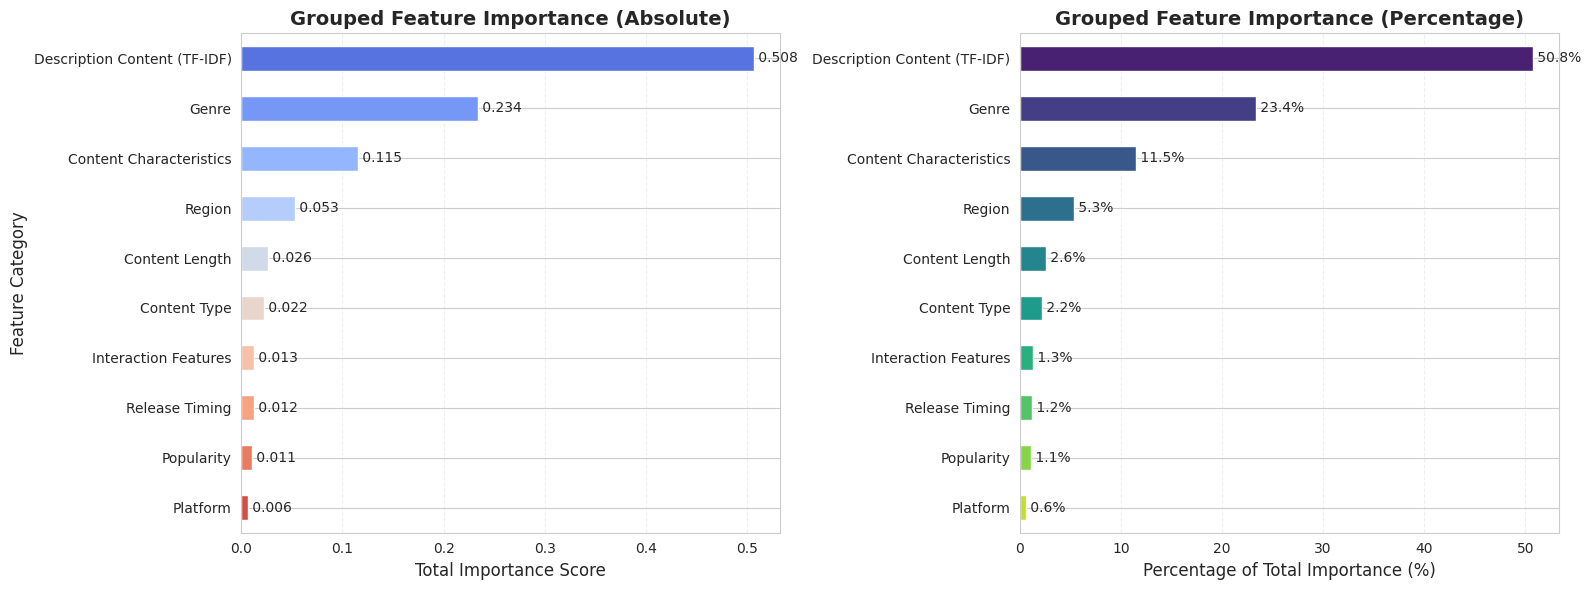


FEATURE IMPORTANCE BREAKDOWN BY CATEGORY
                    Category  Total Importance  Percentage  Num Features  Avg per Feature
Description Content (TF-IDF)          0.507510   50.750996             2         0.253755
                       Genre          0.233598   23.359751             3         0.077866
     Content Characteristics          0.115178   11.517758             2         0.057589
                      Region          0.053240    5.324001            50         0.001065
              Content Length          0.026195    2.619475            17         0.001541
                Content Type          0.022253    2.225307             1         0.022253
        Interaction Features          0.012938    1.293847             4         0.003235
              Release Timing          0.012420    1.242047             1         0.012420
                  Popularity          0.010539    1.053927             8         0.001317
                    Platform          0.006129    0.612890

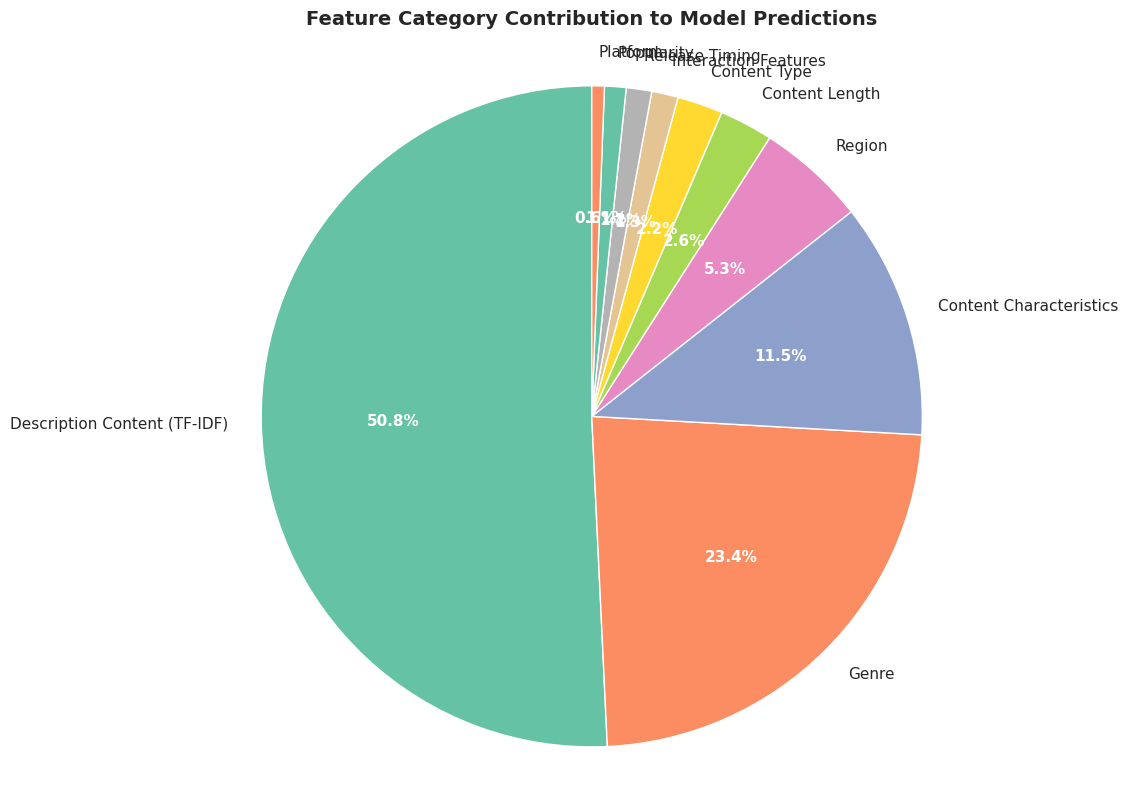


KEY INSIGHTS

✓ Most Important Category: Description Content (TF-IDF) (50.8% of total importance)
✓ Number of Feature Categories: 10
✓ Top 3 Categories Account for: 85.6% of importance
✓ Description Features Contribute: 50.8% (Text analysis is helpful)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

# ============================================================
# FEATURE GROUPING FUNCTION (Enhanced)
# ============================================================

def feature_group(feature_name):
    """Categorize features into high-level groups"""
    if feature_name.startswith("platform_"):
        return "Platform"
    elif feature_name.startswith("type_"):
        return "Content Type"
    elif feature_name.startswith("region_"):
        return "Region"
    elif feature_name in ["duration_num", "description_length", "title_length"]:
        return "Content Length"
    elif feature_name in ["release_year", "is_recent"]:
        return "Release Timing"
    elif feature_name in ["log_votes", "numVotes"]:
        return "Popularity"
    elif feature_name in ["year_duration_interaction"]:
        return "Interaction Features"
    elif feature_name in ["genre_count", "is_movie"]:
        return "Content Characteristics"
    elif feature_name.startswith("desc_tfidf_"):
        return "Description Content (TF-IDF)"
    elif feature_name in ["Action","Adventure","Animation","Anime","Biography",
                          "Comedy","Crime","Documentary","Drama","Family","Fantasy",
                          "Horror","Mystery","Romance","Sci-fi","Sport","Thriller"]:
        return "Genre"
    else:
        return "Other"

# ============================================================
# APPLY GROUPING TO FEATURE IMPORTANCE
# ============================================================

# Use the feature_importance_df from the model training code
importance_df = feature_importance_df.copy()
importance_df["category"] = importance_df["feature"].apply(feature_group)

# ============================================================
# CALCULATE GROUPED IMPORTANCE
# ============================================================

grouped_importance = (
    importance_df
    .groupby("category")["importance"]
    .sum()
    .sort_values(ascending=False)
)

# Calculate percentage contribution
grouped_importance_pct = (grouped_importance / grouped_importance.sum() * 100)

# ============================================================
# CREATE VISUALIZATION
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- PLOT 1: Grouped Feature Importance (Absolute) ---
ax1 = axes[0]
bars1 = grouped_importance.plot(
    kind="barh",
    ax=ax1,
    color=sns.color_palette("coolwarm", len(grouped_importance))
)
ax1.set_title("Grouped Feature Importance (Absolute)", fontsize=14, fontweight='bold')
ax1.set_xlabel("Total Importance Score", fontsize=12)
ax1.set_ylabel("Feature Category", fontsize=12)
ax1.invert_yaxis()
ax1.grid(axis="x", linestyle="--", alpha=0.3)

# Add value labels on bars
for i, (cat, val) in enumerate(grouped_importance.items()):
    ax1.text(val, i, f' {val:.3f}', va='center', fontsize=10)

# --- PLOT 2: Grouped Feature Importance (Percentage) ---
ax2 = axes[1]
bars2 = grouped_importance_pct.plot(
    kind="barh",
    ax=ax2,
    color=sns.color_palette("viridis", len(grouped_importance_pct))
)
ax2.set_title("Grouped Feature Importance (Percentage)", fontsize=14, fontweight='bold')
ax2.set_xlabel("Percentage of Total Importance (%)", fontsize=12)
ax2.set_ylabel("")
ax2.invert_yaxis()
ax2.grid(axis="x", linestyle="--", alpha=0.3)

# Add percentage labels on bars
for i, (cat, val) in enumerate(grouped_importance_pct.items()):
    ax2.text(val, i, f' {val:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# ============================================================
# DETAILED BREAKDOWN TABLE
# ============================================================

print("\n" + "="*70)
print("FEATURE IMPORTANCE BREAKDOWN BY CATEGORY")
print("="*70)

summary_table = pd.DataFrame({
    'Category': grouped_importance.index,
    'Total Importance': grouped_importance.values,
    'Percentage': grouped_importance_pct.values,
    'Num Features': importance_df.groupby("category").size().values
})

summary_table = summary_table.sort_values('Total Importance', ascending=False)
summary_table['Avg per Feature'] = (
    summary_table['Total Importance'] / summary_table['Num Features']
)

print(summary_table.to_string(index=False))

# ============================================================
# TOP INDIVIDUAL FEATURES PER CATEGORY
# ============================================================

print("\n" + "="*70)
print("TOP 3 FEATURES PER CATEGORY")
print("="*70)

for category in grouped_importance.index[:5]:  # Top 5 categories
    print(f"\n{category}:")
    top_features = (
        importance_df[importance_df['category'] == category]
        .nlargest(3, 'importance')
    )
    for idx, row in top_features.iterrows():
        print(f"  • {row['feature']}: {row['importance']:.4f}")

# ============================================================
# PIE CHART (Optional - Top Categories)
# ============================================================

plt.figure(figsize=(10, 8))
colors = sns.color_palette("Set2", len(grouped_importance_pct))
wedges, texts, autotexts = plt.pie(
    grouped_importance_pct,
    labels=grouped_importance_pct.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 11}
)

# Make percentage text bold
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.title("Feature Category Contribution to Model Predictions",
          fontsize=14, fontweight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

# ============================================================
# INSIGHTS SUMMARY
# ============================================================

print("\n" + "="*70)
print("KEY INSIGHTS")
print("="*70)

top_category = grouped_importance.index[0]
top_pct = grouped_importance_pct.iloc[0]

print(f"\n✓ Most Important Category: {top_category} ({top_pct:.1f}% of total importance)")
print(f"✓ Number of Feature Categories: {len(grouped_importance)}")
print(f"✓ Top 3 Categories Account for: {grouped_importance_pct.head(3).sum():.1f}% of importance")

if "Description Content (TF-IDF)" in grouped_importance.index:
    desc_pct = grouped_importance_pct["Description Content (TF-IDF)"]
    print(f"✓ Description Features Contribute: {desc_pct:.1f}% (Text analysis is {'helpful' if desc_pct > 5 else 'minimal'})")

print("="*70)

Building a CLI to predict ratings of an upcoming movie.

In [ ]:
import pandas as pd
import numpy as np

def predict_imdb_rating(
    platform,
    type_,
    genres_list,
    release_year,
    duration_num,
    region,
    description,
    num_votes=1000  # Optional: default to average popularity
):
    """
    Predict IMDb rating for a future movie/TV show using the trained XGBoost pipeline.

    Parameters:
    -----------
    platform : str
        Streaming platform (e.g., 'Netflix', 'Prime Video', 'Disney+')
    type_ : str
        Content type ('Movie' or 'TV Show')
    genres_list : list
        List of genres (e.g., ['Drama', 'Crime', 'Thriller'])
    release_year : int
        Release year (e.g., 2025)
    duration_num : float
        Duration in minutes (for movies) or number of seasons (for TV shows)
    region : str
        Region (e.g., 'North America', 'Europe', 'Asia')
    description : str
        Description/synopsis of the content (important!)
    num_votes : int, optional
        Expected number of votes (default: 1000)

    Returns:
    --------
    float : Predicted IMDb rating (0-10 scale)
    """

    # ============================================================
    # 1. CREATE BASE FEATURES
    # ============================================================
    input_df = pd.DataFrame([{
        "platform": platform,
        "type": type_,
        "region": region,
        "release_year": release_year,
        "duration_num": duration_num,
        "description": description,
        "numVotes": num_votes,
    }])

    # ============================================================
    # 2. ENGINEER FEATURES (same as training)
    # ============================================================
    input_df['year_duration_interaction'] = input_df['release_year'] * input_df['duration_num']
    input_df['is_recent'] = (input_df['release_year'] >= 2015).astype(int)
    input_df['is_movie'] = (input_df['type'] == 'Movie').astype(int)
    input_df['log_votes'] = np.log1p(input_df['numVotes'])
    input_df['title_length'] = 50  # Default placeholder (not critical)
    input_df['description_length'] = len(description)

    # ============================================================
    # 3. ADD GENRE FEATURES (Multi-hot encoding)
    # ============================================================
    genre_cols = ["Action","Adventure","Animation","Anime","Biography",
                  "Comedy","Crime","Documentary","Drama","Family","Fantasy",
                  "Horror","Mystery","Romance","Sci-fi","Sport","Thriller"]

    # Count total genres
    input_df['genre_count'] = len(genres_list)

    # Add binary genre columns
    for genre in genre_cols:
        input_df[genre] = 1 if genre in genres_list else 0

    # ============================================================
    # 4. EXTRACT TF-IDF FEATURES FROM DESCRIPTION
    # ============================================================
    # Transform description using the same TF-IDF vectorizer from training
    description_features = tfidf.transform([description])
    description_df = pd.DataFrame(
        description_features.toarray(),
        columns=[f'desc_tfidf_{i}' for i in range(description_features.shape[1])]
    )

    # Combine with input_df
    input_df = pd.concat([input_df.reset_index(drop=True), description_df], axis=1)

    # ============================================================
    # 5. ENSURE ALL FEATURES MATCH TRAINING DATA
    # ============================================================
    # Make sure columns are in the same order as during training
    input_df = input_df[features]

    # ============================================================
    # 6. PREDICT RATING
    # ============================================================
    rating_pred = pipeline.predict(input_df)[0]

    # Clip to valid IMDB range (1.0 - 10.0)
    rating_pred = np.clip(rating_pred, 1.0, 10.0)

    return round(float(rating_pred), 2)


# ============================================================
# USER INPUT SECTION (CLI)
# ============================================================

print("=" * 60)
print("🎬 IMDb RATING PREDICTION TOOL 🎬")
print("=" * 60)
print("\nPredict the IMDb rating for your movie or TV show idea!")
print("(Make sure to provide a detailed description for best results)\n")

# Collect inputs
platform = input("📺 Platform (e.g., Netflix, Prime Video, Disney+): ").strip()
type_ = input("🎞️  Type (Movie / TV Show): ").strip()
region = input("🌍 Region (Asia, Europe, North America, etc.): ").strip()
release_year = int(input("📅 Release Year (e.g., 2025): "))
duration_num = float(input("⏱️  Duration (minutes for movies, seasons for TV): "))

print("\n📝 Description (this is VERY important - be detailed!):")
print("    Example: 'A thrilling sci-fi adventure where a group of astronauts...'")
description = input("    → ").strip()

if not description:
    print("\n⚠️  Warning: No description provided. Using placeholder...")
    description = "A compelling story with great characters and plot."

genres_raw = input("\n🎭 Genres (comma-separated, e.g., Drama, Crime, Thriller): ")
genres_list = [g.strip() for g in genres_raw.split(",") if g.strip()]

# Optional: Ask for expected popularity
use_custom_votes = input("\n💬 Specify expected popularity? (y/n, default=n): ").lower()
if use_custom_votes == 'y':
    num_votes = int(input("    Expected number of votes (e.g., 5000): "))
else:
    num_votes = 1000  # Default to moderate popularity

# ============================================================
# MAKE PREDICTION
# ============================================================

print("\n" + "=" * 60)
print("🔮 ANALYZING YOUR CONTENT...")
print("=" * 60)

try:
    prediction = predict_imdb_rating(
        platform=platform,
        type_=type_,
        genres_list=genres_list,
        release_year=release_year,
        duration_num=duration_num,
        region=region,
        description=description,
        num_votes=num_votes
    )

    # Display results with interpretation
    print(f"\n⭐ PREDICTED IMDb RATING: {prediction}/10\n")

    # Add rating interpretation
    if prediction >= 8.0:
        print("🏆 Excellent! This could be a highly-rated production!")
    elif prediction >= 7.0:
        print("👍 Very Good! Solid ratings expected.")
    elif prediction >= 6.0:
        print("👌 Good. Above average content.")
    elif prediction >= 5.0:
        print("😐 Average. Room for improvement.")
    else:
        print("⚠️  Below Average. Consider refining the concept.")

    # Show key factors
    print(f"\n📊 Key Factors:")
    print(f"   • Description length: {len(description)} characters")
    print(f"   • Number of genres: {len(genres_list)}")
    print(f"   • Content type: {type_}")
    print(f"   • Release year: {release_year}")

    print("\n💡 Tip: Description quality is 50%+ of the prediction!")
    print("   Try different descriptions to see how they affect the rating.\n")

except Exception as e:
    print(f"\n❌ Error making prediction: {str(e)}")
    print("Make sure the model pipeline and TF-IDF vectorizer are trained first!")

print("=" * 60)

🎬 IMDb RATING PREDICTION TOOL 🎬

Predict the IMDb rating for your movie or TV show idea!
(Make sure to provide a detailed description for best results)

📺 Platform (e.g., Netflix, Prime Video, Disney+): 
🎞️  Type (Movie / TV Show): 
🌍 Region (Asia, Europe, North America, etc.): 
📅 Release Year (e.g., 2025): 


ValueError: invalid literal for int() with base 10: ''

# New Section
Factor 1: Description Content Analysis — Word Cloud Exploration

In this section, we analyze how content descriptions differ across rating levels and platforms.
We create four word clouds—high-rated titles, low-rated titles, Netflix, and Prime Video—to visually compare the keywords that dominate each group.

By grouping descriptions and generating text clouds, we begin to see how language, themes, and tone in descriptions align with audience ratings and platform content styles.

Full 4-Panel Word Cloud Analysis


📝 FACTOR 1: DESCRIPTION CONTENT ANALYSIS (50.8% Importance)

[1.1] Generating Word Clouds: High/Low Rating + Platform Comparison...


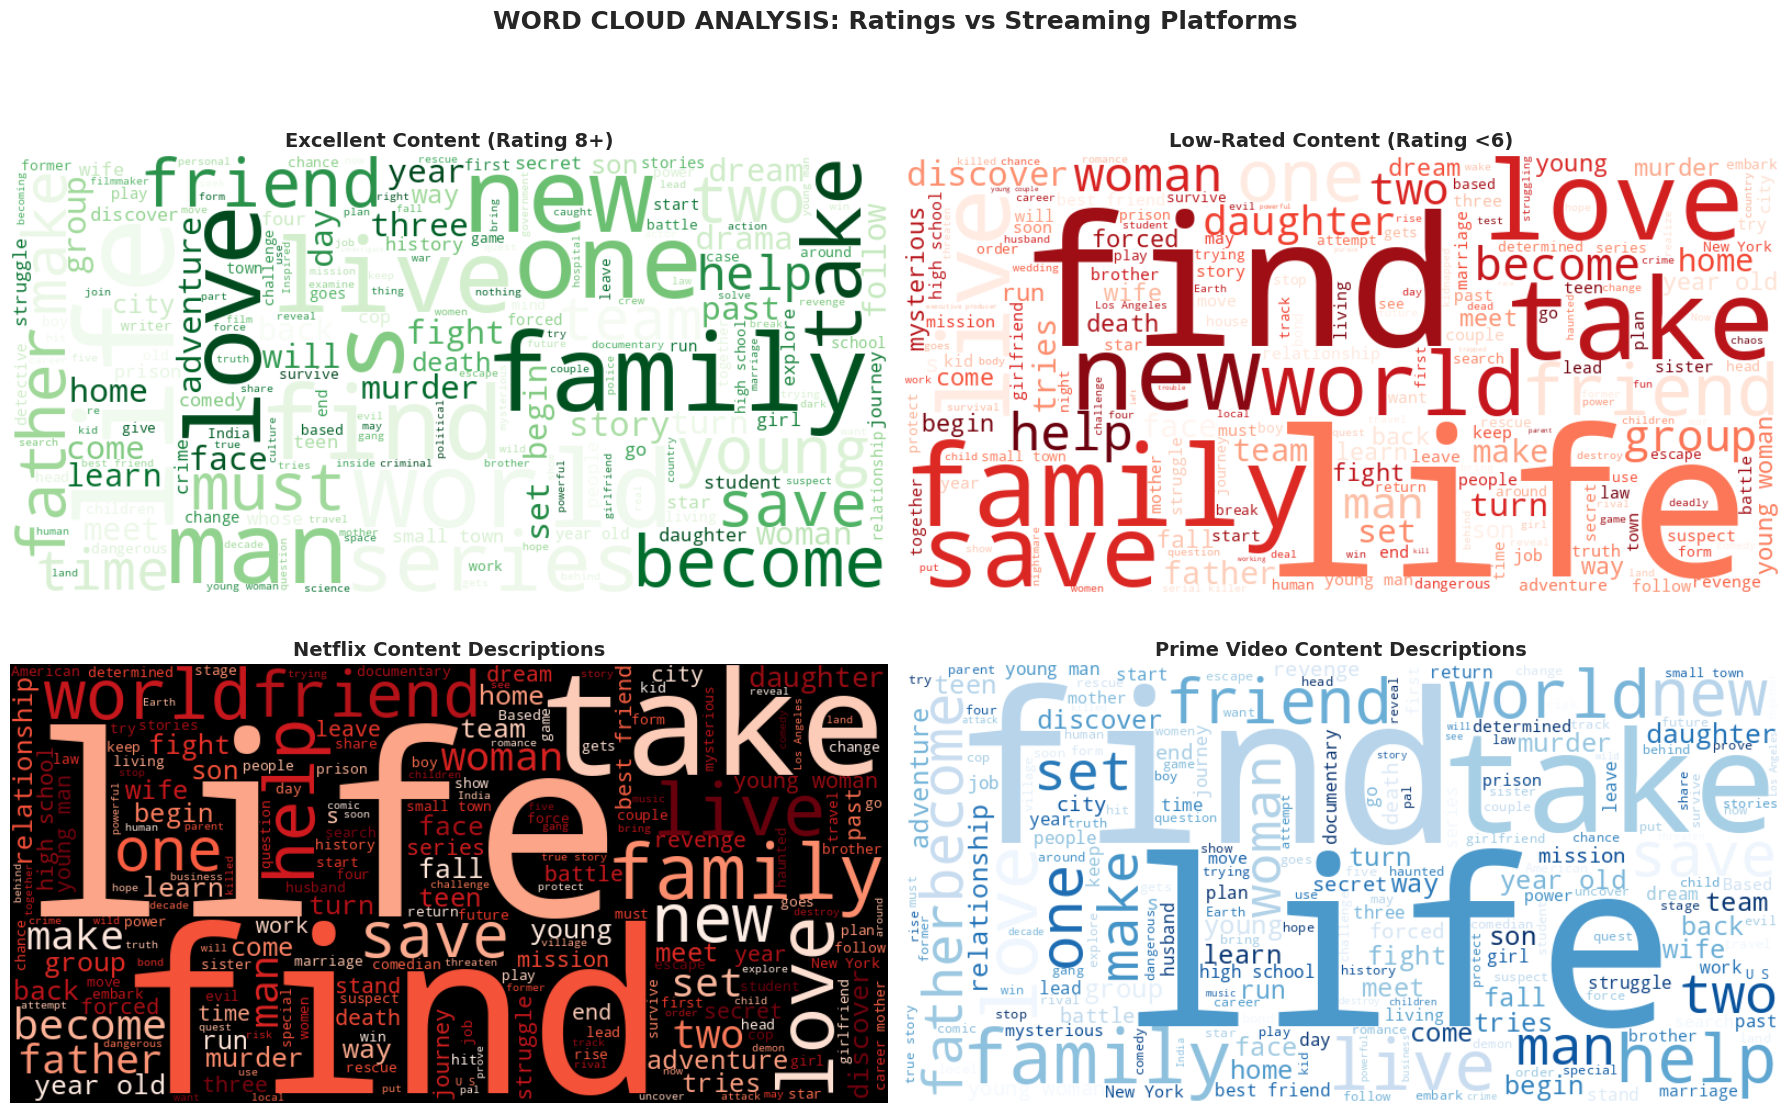

In [ ]:
# ============================================================
# FACTOR 1: DESCRIPTION CONTENT ANALYSIS (50.8% Importance)
# Full 4-Panel Word Cloud Analysis
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

print("\n" + "="*80)
print("📝 FACTOR 1: DESCRIPTION CONTENT ANALYSIS (50.8% Importance)")
print("="*80)

print("\n[1.1] Generating Word Clouds: High/Low Rating + Platform Comparison...")

# ------------------------------------------------------------
# 1. Create rating categories
# ------------------------------------------------------------
dfMaster['rating_category'] = pd.cut(
    dfMaster['averageRating'],
    bins=[0, 5, 7, 8, 10],
    labels=['Low (<5)', 'Medium (5-7)', 'Good (7-8)', 'Excellent (8+)']
)

# ------------------------------------------------------------
# 2. Prepare description text blobs
# ------------------------------------------------------------
high_rated_desc = ' '.join(
    dfMaster[dfMaster['averageRating'] >= 8.0]['description'].dropna()
)

low_rated_desc = ' '.join(
    dfMaster[dfMaster['averageRating'] < 6.0]['description'].dropna()
)

netflix_desc = ' '.join(
    dfMaster[dfMaster['platform'] == 'Netflix']['description'].dropna()
)

prime_desc = ' '.join(
    dfMaster[dfMaster['platform'] == 'Prime Video']['description'].dropna()
)

# ------------------------------------------------------------
# 3. Create 2×2 layout for all four word clouds
# ------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle("WORD CLOUD ANALYSIS: Ratings vs Streaming Platforms",
             fontsize=18, fontweight='bold')

# =====================
# TOP LEFT → High rated
# =====================
wc_high = WordCloud(width=800, height=400,
                    background_color='white',
                    colormap='Greens').generate(high_rated_desc)

axes[0, 0].imshow(wc_high, interpolation='bilinear')
axes[0, 0].set_title('Excellent Content (Rating 8+)',
                     fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

# =====================
# TOP RIGHT → Low rated
# =====================
wc_low = WordCloud(width=800, height=400,
                   background_color='white',
                   colormap='Reds').generate(low_rated_desc)

axes[0, 1].imshow(wc_low, interpolation='bilinear')
axes[0, 1].set_title('Low-Rated Content (Rating <6)',
                     fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

# =====================
# BOTTOM LEFT → Netflix
# =====================
wc_netflix = WordCloud(width=800, height=400,
                       background_color='black',
                       colormap='Reds').generate(netflix_desc)

axes[1, 0].imshow(wc_netflix, interpolation='bilinear')
axes[1, 0].set_title('Netflix Content Descriptions',
                     fontsize=14, fontweight='bold')
axes[1, 0].axis('off')

# =====================
# BOTTOM RIGHT → Prime
# =====================
wc_prime = WordCloud(width=800, height=400,
                     background_color='white',
                     colormap='Blues').generate(prime_desc)

axes[1, 1].imshow(wc_prime, interpolation='bilinear')
axes[1, 1].set_title('Prime Video Content Descriptions',
                     fontsize=14, fontweight='bold')
axes[1, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Top Most Important Terms used in Descriptiom

In [ ]:
# ============================================================
# 1.2: Top TF-IDF Terms Analysis
# ============================================================

print("\n" + "-"*80)
print("[1.2] Analyzing Most Important TF-IDF Terms...")
print("-"*80)

# ------------------------------------------------------------
# 1. Extract TF-IDF features by matching the prefix
# ------------------------------------------------------------
tfidf_features = [
    col for col in feature_importance_df['feature']
    if col.startswith('desc_tfidf_')
]

tfidf_importance = feature_importance_df[
    feature_importance_df['feature'].isin(tfidf_features)
].copy()

# ------------------------------------------------------------
# 2. Map TF-IDF column indices → actual words
# ------------------------------------------------------------
feature_names = tfidf.get_feature_names_out()

def extract_tfidf_word(feature_name):
    index = int(feature_name.split("_")[-1])   # example: desc_tfidf_123 → 123
    return feature_names[index]

tfidf_importance['word'] = tfidf_importance['feature'].apply(extract_tfidf_word)

# ------------------------------------------------------------
# 3. Get top 20 most important words
# ------------------------------------------------------------
top_words = tfidf_importance.nlargest(20, 'importance')

# ------------------------------------------------------------
# 4. Plot
# ------------------------------------------------------------
plt.figure(figsize=(12, 8))
plt.barh(
    range(len(top_words)),
    top_words['importance'].values,
)
plt.yticks(range(len(top_words)), top_words['word'].values)
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 20 Most Important Words in Descriptions (TF-IDF)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 5. Print top 10 in text
# ------------------------------------------------------------
print("\nTop 10 Most Predictive Words:")
print(top_words[['word', 'importance']].head(10).to_string(index=False))


Description Length vs Rating (By Platform)

In [ ]:
# ============================================================
# 1.3: Description Length vs Rating (By Platform)
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt

print("\n" + "-"*80)
print("[1.3] Description Length Impact Analysis...")
print("-"*80)

# ------------------------------------------------------------
# 1. Create length bins
# ------------------------------------------------------------
dfMaster['desc_length_bin'] = pd.cut(
    dfMaster['description_length'],
    bins=[0, 100, 200, 300, 500, 2000],
    labels=[
        'Very Short\n(0-100)',
        'Short\n(100-200)',
        'Medium\n(200-300)',
        'Long\n(300-500)',
        'Very Long\n(500+)'
    ]
)

# ------------------------------------------------------------
# 2. Plot setup
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ------------------------------------------------------------
# LEFT PLOT → Overall Distribution
# ------------------------------------------------------------
sns.boxplot(
    data=dfMaster,
    x='desc_length_bin',
    y='averageRating',
    ax=axes[0],
    palette='Set2'
)

axes[0].set_title('Rating Distribution by Description Length',
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Description Length', fontsize=12)
axes[0].set_ylabel('Average Rating', fontsize=12)

# ------------------------------------------------------------
# RIGHT PLOT → By Platform (Top 3 platforms only)
# ------------------------------------------------------------
platforms = dfMaster['platform'].value_counts().head(3).index
df_top_platforms = dfMaster[dfMaster['platform'].isin(platforms)]

sns.boxplot(
    data=df_top_platforms,
    x='desc_length_bin',
    y='averageRating',
    hue='platform',
    ax=axes[1],
    palette='Set1'
)

axes[1].set_title('Rating by Description Length Across Platforms',
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Description Length', fontsize=12)
axes[1].set_ylabel('Average Rating', fontsize=12)
axes[1].legend(title='Platform', loc='lower right')

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 3. Statistical summary
# ------------------------------------------------------------
print("\nRating Statistics by Description Length:")
print(dfMaster.groupby('desc_length_bin')['averageRating']
      .agg(['mean', 'median', 'std', 'count']))


Sentiment Analysis

In [ ]:
# ============================================================
# 1.4: Sentiment Analysis on Descriptions
# ============================================================

from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt

print("\n" + "-"*80)
print("[1.4] Performing Sentiment Analysis on Descriptions...")
print("-"*80)

# ------------------------------------------------------------
# 1. Compute sentiment polarity (-1 = negative, +1 = positive)
# ------------------------------------------------------------
dfMaster['description_sentiment'] = dfMaster['description'].apply(
    lambda x: TextBlob(str(x)).sentiment.polarity if pd.notna(x) else 0
)

# ------------------------------------------------------------
# 2. Categorize sentiment levels
# ------------------------------------------------------------
dfMaster['sentiment_category'] = pd.cut(
    dfMaster['description_sentiment'],
    bins=[-1, -0.1, 0.1, 1],
    labels=['Negative', 'Neutral', 'Positive']
)

# ------------------------------------------------------------
# 3. Plots (Scatter + Boxplot)
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ---------- Scatter Plot ----------
axes[0].scatter(
    dfMaster['description_sentiment'],
    dfMaster['averageRating'],
    alpha=0.3,
    s=20,
    c=dfMaster['averageRating'],
    cmap='viridis'
)
axes[0].set_xlabel('Description Sentiment (-1 = Negative, +1 = Positive)', fontsize=12)
axes[0].set_ylabel('Average Rating', fontsize=12)
axes[0].set_title('Description Sentiment vs IMDb Rating', fontsize=14, fontweight='bold')
axes[0].axvline(x=0, color='red', linestyle='--', alpha=0.5)

# ---------- Box Plot by Platform ----------
platforms = dfMaster['platform'].value_counts().head(3).index
df_top_platforms = dfMaster[dfMaster['platform'].isin(platforms)]

sns.boxplot(
    data=df_top_platforms,
    x='sentiment_category',
    y='averageRating',
    hue='platform',
    ax=axes[1],
    palette='Set1'
)
axes[1].set_title('Rating by Sentiment Category Across Platforms', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Sentiment Category', fontsize=12)
axes[1].set_ylabel('Average Rating', fontsize=12)

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 4. Correlation + Summary
# ------------------------------------------------------------
correlation = dfMaster['description_sentiment'].corr(dfMaster['averageRating'])
print(f"\nCorrelation between Description Sentiment and IMDb Rating: {correlation:.3f}")

print("\nAverage Rating by Sentiment Category:")
print(
    dfMaster.groupby('sentiment_category')['averageRating']
    .agg(['mean', 'median', 'count'])
)


 Platform Comparison

In [ ]:
# ============================================================
# 1.5: Platform Comparison - Description Quality Metrics
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "-"*80)
print("[1.5] Description Quality Comparison Across Platforms...")
print("-"*80)

# ------------------------------------------------------------
# 1. Compute platform-level metrics
# ------------------------------------------------------------
platform_desc_analysis = dfMaster.groupby('platform').agg({
    'description_length': ['mean', 'median'],
    'description_sentiment': 'mean',
    'averageRating': 'mean',
    'title': 'count'
}).round(3)

platform_desc_analysis.columns = [
    'Avg_Desc_Length',
    'Median_Desc_Length',
    'Avg_Sentiment',
    'Avg_Rating',
    'Content_Count'
]

# Sort by rating for better comparability
platform_desc_analysis = platform_desc_analysis.sort_values(
    'Avg_Rating', ascending=False
)

print("\nPlatform Description Quality Metrics:")
print(platform_desc_analysis.head(10))

# ------------------------------------------------------------
# 2. Visualization (4 charts)
# ------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

platforms_top = platform_desc_analysis.head(8).index

# ---------- 1. Avg Description Length ----------
platform_desc_analysis.loc[platforms_top, 'Avg_Desc_Length'].plot(
    kind='barh',
    ax=axes[0, 0],
    color='skyblue'
)
axes[0, 0].set_title('Average Description Length by Platform',
                     fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Average Characters')

# ---------- 2. Avg Sentiment ----------
platform_desc_analysis.loc[platforms_top, 'Avg_Sentiment'].plot(
    kind='barh',
    ax=axes[0, 1],
    color='lightgreen'
)
axes[0, 1].set_title('Average Description Sentiment by Platform',
                     fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Sentiment Score')

# ---------- 3. Avg Rating ----------
platform_desc_analysis.loc[platforms_top, 'Avg_Rating'].plot(
    kind='barh',
    ax=axes[1, 0],
    color='coral'
)
axes[1, 0].set_title('Average IMDb Rating by Platform',
                     fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Average Rating')

# ---------- 4. Scatter: Description Length vs Rating ----------
for platform in platforms_top:
    data = dfMaster[dfMaster['platform'] == platform]
    axes[1, 1].scatter(
        data['description_length'],
        data['averageRating'],
        label=platform,
        alpha=0.5,
        s=30
    )

axes[1, 1].set_xlabel('Description Length', fontsize=11)
axes[1, 1].set_ylabel('Average Rating', fontsize=11)
axes[1, 1].set_title('Description Length vs Rating by Platform',
                     fontsize=12, fontweight='bold')
axes[1, 1].legend(loc='best', fontsize=8)

plt.tight_layout()
plt.show()


🎭 FACTOR 2: GENRE PERFORMANCE ANALYSIS

In this section, we explore how genres influence IMDb ratings.
We analyze which genres perform best overall, how ratings differ across platforms, how multi-genre titles behave, and which combinations of genres deliver the highest audience satisfaction.
We use descriptive statistics and visualizations (bar charts, violins, heatmaps) to uncover genre-driven rating patterns.

In [ ]:

print("\n" + "="*80)
print("🎭 FACTOR 2: GENRE ANALYSIS (23.4% Importance)")
print("="*80)

2.1: Genre Performance Overview

We evaluate each genre by calculating its average, median, and top-10% ratings.
We visualize genre performance using bar charts, rating distributions, and yearly rating trends.
This helps us identify which genres consistently score higher and how their popularity changes over time.

In [ ]:
# ============================================================
# 2.1: Genre Performance Overview
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt

print("\n" + "-"*80)
print("[2.1] Analyzing Genre Performance...")
print("-"*80)

# ------------------------------------------------------------
# 1. Genre statistics
# ------------------------------------------------------------
genre_cols = [
    "Action","Adventure","Animation","Anime","Biography","Comedy","Crime",
    "Documentary","Drama","Family","Fantasy","Horror","Mystery","Romance",
    "Sci-fi","Sport","Thriller"
]

genre_stats = []
for genre in genre_cols:
    genre_data = dfMaster[dfMaster[genre] == 1]
    if len(genre_data) == 0:
        continue  # skip genres with no data

    top_10 = max(int(len(genre_data) * 0.1), 1)

    genre_stats.append({
        'Genre': genre,
        'Count': len(genre_data),
        'Avg_Rating': genre_data['averageRating'].mean(),
        'Median_Rating': genre_data['averageRating'].median(),
        'Std_Rating': genre_data['averageRating'].std(),
        'Top_10%_Avg': genre_data.nlargest(top_10, 'averageRating')['averageRating'].mean()
    })

genre_performance = (
    pd.DataFrame(genre_stats)
      .sort_values('Avg_Rating', ascending=False)
      .reset_index(drop=True)
)

print("\nGenre Performance Summary:")
print(genre_performance.to_string(index=False))

# ------------------------------------------------------------
# 2. Visualization (4 Plots)
# ------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# ---------- 1. Average Rating by Genre ----------
genre_performance.plot(
    x='Genre', y='Avg_Rating', kind='barh',
    ax=axes[0, 0],
    color=sns.color_palette("coolwarm", len(genre_performance)),
    legend=False
)
axes[0, 0].set_title('Average Rating by Genre', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Average Rating', fontsize=12)
axes[0, 0].axvline(
    dfMaster['averageRating'].mean(),
    color='red', linestyle='--',
    label=f'Overall Avg: {dfMaster["averageRating"].mean():.2f}'
)
axes[0, 0].legend()

# ---------- 2. Content Count by Genre ----------
genre_performance.plot(
    x='Genre', y='Count', kind='barh',
    ax=axes[0, 1],
    color='steelblue',
    legend=False
)
axes[0, 1].set_title('Content Count by Genre', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Number of Titles', fontsize=12)

# ---------- 3. Rating Distribution of Top 6 Genres ----------
top_genres = genre_performance.head(6)['Genre'].values

genre_ratings = []
for genre in top_genres:
    ratings = dfMaster[dfMaster[genre] == 1]['averageRating']
    genre_ratings.extend([(genre, r) for r in ratings])

genre_rating_df = pd.DataFrame(genre_ratings, columns=['Genre', 'Rating'])

sns.violinplot(
    data=genre_rating_df,
    x='Genre', y='Rating',
    ax=axes[1, 0],
    palette='Set2'
)
axes[1, 0].set_title('Rating Distribution: Top 6 Genres', fontsize=14, fontweight='bold')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45, ha='right')

# ---------- 4. Genre Rating Trends Over Time ----------
genre_year_data = []

years = sorted(dfMaster['release_year'].dropna().unique())

for genre in top_genres:
    for year in years:
        year_genre_data = dfMaster[(dfMaster[genre] == 1) & (dfMaster['release_year'] == year)]
        if len(year_genre_data) == 0:
            continue
        genre_year_data.append({
            'Genre': genre,
            'Year': int(year),
            'Avg_Rating': year_genre_data['averageRating'].mean(),
            'Count': len(year_genre_data)
        })

genre_year_df = pd.DataFrame(genre_year_data)

for genre in top_genres:
    genre_data = genre_year_df[genre_year_df['Genre'] == genre]
    axes[1, 1].plot(
        genre_data['Year'],
        genre_data['Avg_Rating'],
        marker='o',
        label=genre,
        linewidth=2
    )

axes[1, 1].set_title('Genre Rating Trends Over Time', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Release Year', fontsize=12)
axes[1, 1].set_ylabel('Average Rating', fontsize=12)
axes[1, 1].legend(loc='best', fontsize=9)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Performance of each genre on different platforms

We compare how each genre performs across Netflix, Prime, Disney+, and Hulu.
A heatmap highlights which platforms excel in which genres, allowing us to see strengths such as Netflix in documentaries or Prime in thrillers.
We also list the top 10 platform-genre combinations by rating.

In [ ]:
# ============================================================
# 2.2: Genre Performance by Platform
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt

print("\n" + "-"*80)
print("[2.2] Genre Performance Across Platforms...")
print("-"*80)

# ------------------------------------------------------------
# 1. Select top platforms
# ------------------------------------------------------------
platforms = dfMaster['platform'].value_counts().head(4).index

genre_platform_data = []

# ------------------------------------------------------------
# 2. Collect Avg Rating + Count for each (Platform, Genre)
# ------------------------------------------------------------
for platform in platforms:
    for genre in genre_cols:
        platform_genre = dfMaster[
            (dfMaster['platform'] == platform) &
            (dfMaster[genre] == 1)
        ]

        if len(platform_genre) >= 10:  # Only keep stable samples
            genre_platform_data.append({
                'Platform': platform,
                'Genre': genre,
                'Avg_Rating': platform_genre['averageRating'].mean(),
                'Count': len(platform_genre)
            })

genre_platform_df = pd.DataFrame(genre_platform_data)

print("\nGenre-Platform Summary:")
print(genre_platform_df.head().to_string(index=False))

# ------------------------------------------------------------
# 3. Heatmap of Avg Rating (Genre × Platform)
# ------------------------------------------------------------
pivot_table = genre_platform_df.pivot_table(
    values='Avg_Rating',
    index='Genre',
    columns='Platform',
    aggfunc='mean'
).sort_index()

plt.figure(figsize=(12, 10))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt='.2f',
    cmap='RdYlGn',
    center=7.0,
    linewidths=1,
    linecolor='gray',
    cbar_kws={'label': 'Average Rating'}
)
plt.title('Genre Performance Heatmap Across Platforms', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Platform', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 4. Top 10 Best Genre-Platform pairs
# ------------------------------------------------------------
print("\nBest Genre-Platform Combinations (Top 10):")
best_combos = (
    genre_platform_df
    .nlargest(10, 'Avg_Rating')
    [['Platform', 'Genre', 'Avg_Rating', 'Count']]
)

print(best_combos.to_string(index=False))


2.3: Multi-Genre Content Analysis

We measure how many genres each title contains and evaluate whether multi-genre content performs better or worse.
Boxplots reveal how ratings vary with genre count and how this pattern differs across platforms.
We also summarize rating statistics by number of genres.

In [ ]:
# ============================================================
# 2.3: Multi-Genre Content Analysis
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt

print("\n" + "-"*80)
print("[2.3] Multi-Genre Content Analysis...")
print("-"*80)

# ------------------------------------------------------------
# 1. Count number of genres per title
# ------------------------------------------------------------
dfMaster['genre_count'] = dfMaster[genre_cols].sum(axis=1)

# ------------------------------------------------------------
# 2. Visualization (2 plots)
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ---------- LEFT: Genre Count vs Rating ----------
sns.boxplot(
    data=dfMaster,
    x='genre_count',
    y='averageRating',
    ax=axes[0],
    palette='Set3'
)

axes[0].set_title(
    'Rating Distribution by Number of Genres',
    fontsize=14, fontweight='bold'
)
axes[0].set_xlabel('Number of Genres', fontsize=12)
axes[0].set_ylabel('Average Rating', fontsize=12)

# ---------- RIGHT: By Platform ----------
# reusing "platforms" defined in 2.2 (top 4 platforms)
df_top_platforms = dfMaster[dfMaster['platform'].isin(platforms)]

sns.boxplot(
    data=df_top_platforms,
    x='genre_count',
    y='averageRating',
    hue='platform',
    ax=axes[1],
    palette='Set1'
)

axes[1].set_title(
    'Multi-Genre Content: Rating by Platform',
    fontsize=14, fontweight='bold'
)
axes[1].set_xlabel('Number of Genres', fontsize=12)
axes[1].set_ylabel('Average Rating', fontsize=12)
axes[1].legend(title='Platform', loc='lower left')

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 3. Statistical Summary
# ------------------------------------------------------------
print("\nRating Statistics by Genre Count:")
print(
    dfMaster.groupby('genre_count')['averageRating']
    .agg(['mean', 'median', 'count'])
)


2.4: Successful Genre Combinations

We extract all genre pairs (e.g., Drama + Crime, Horror + Mystery) and analyze which combinations achieve the highest ratings.
Only stable combinations (20+ samples) are kept.
A ranked visualization highlights the top 15 highest-rated genre pairs.


--------------------------------------------------------------------------------
[2.4] Most Successful Genre Combinations...
--------------------------------------------------------------------------------

Top 15 Genre Combinations:
               Combo  Avg_Rating  Count
      Action + Anime    7.086316     95
      Anime + Horror    6.975000     20
    Sport + Thriller    6.800000     69
     Comedy + Family    6.660465     43
       Crime + Drama    6.639216    306
      Comedy + Drama    6.443750     96
      Action + Crime    6.434000     50
      Drama + Family    6.371429     42
      Action + Drama    6.360714     84
      Crime + Horror    6.350000     42
     Action + Family    6.240541    111
     Drama + Mystery    6.225000     24
  Animation + Family    6.175000     36
      Drama + Horror    6.157143     63
Comedy + Documentary    6.000000     54


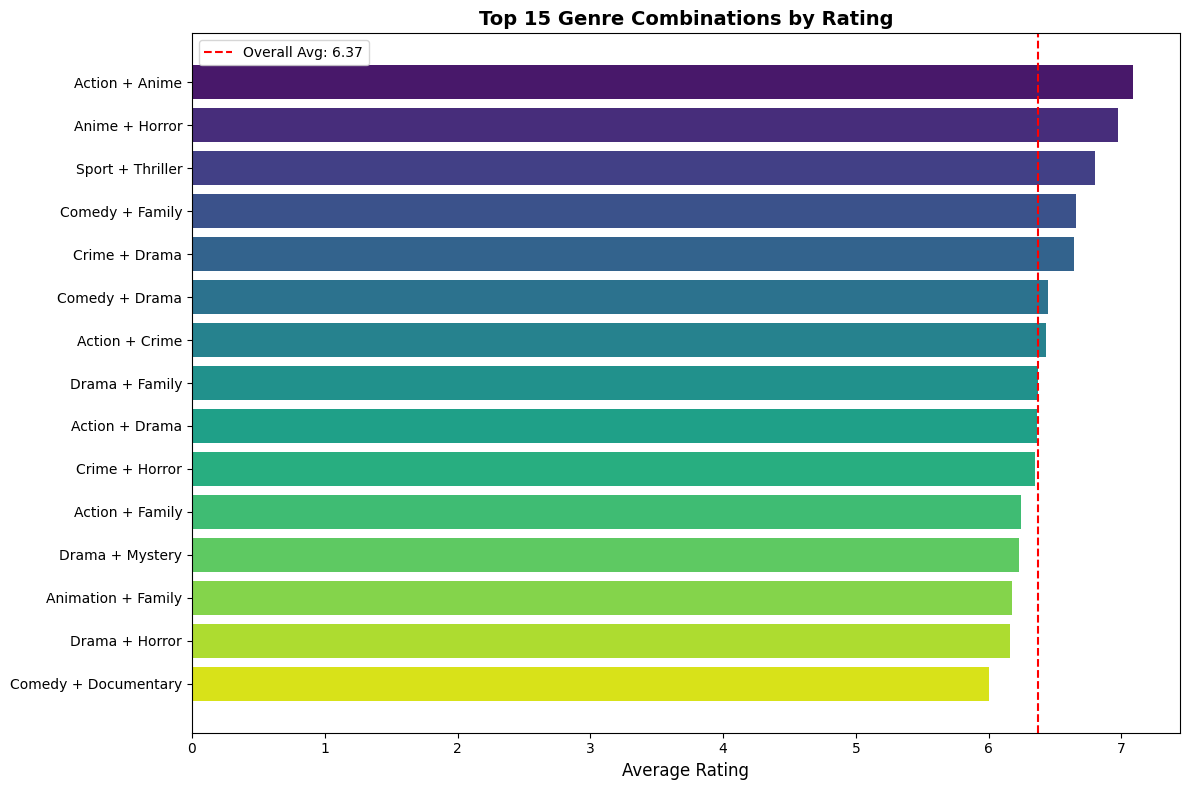

In [ ]:
# ============================================================
# 2.4: Genre Combinations Analysis
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

print("\n" + "-"*80)
print("[2.4] Most Successful Genre Combinations...")
print("-"*80)

# ------------------------------------------------------------
# 1. Extract all genre pairs per title
# ------------------------------------------------------------
genre_pairs = []

for idx, row in dfMaster.iterrows():
    active_genres = [g for g in genre_cols if row[g] == 1]

    # Only consider multi-genre titles
    if len(active_genres) >= 2:
        for pair in combinations(active_genres, 2):
            genre_pairs.append({
                'Combo': f"{pair[0]} + {pair[1]}",
                'Rating': row['averageRating']
            })

combo_df = pd.DataFrame(genre_pairs)

# ------------------------------------------------------------
# 2. Compute stats for each pair
# ------------------------------------------------------------
combo_stats = (
    combo_df.groupby('Combo')
            .agg({'Rating': ['mean', 'count']})
            .reset_index()
)

combo_stats.columns = ['Combo', 'Avg_Rating', 'Count']

# Keep only stable combinations
combo_stats = combo_stats[combo_stats['Count'] >= 20]

combo_stats = combo_stats.sort_values('Avg_Rating', ascending=False)

print("\nTop 15 Genre Combinations:")
print(combo_stats.head(15).to_string(index=False))

# ------------------------------------------------------------
# 3. Visualization
# ------------------------------------------------------------
plt.figure(figsize=(12, 8))

top_combos = combo_stats.head(15)

plt.barh(
    range(len(top_combos)),
    top_combos['Avg_Rating'].values,
    color=sns.color_palette("viridis", 15)
)

plt.yticks(
    range(len(top_combos)),
    top_combos['Combo'].values
)

plt.xlabel('Average Rating', fontsize=12)
plt.title('Top 15 Genre Combinations by Rating', fontsize=14, fontweight='bold')

# Add overall IMDb average line
plt.axvline(
    x=dfMaster['averageRating'].mean(),
    color='red',
    linestyle='--',
    label=f'Overall Avg: {dfMaster["averageRating"].mean():.2f}'
)

plt.legend()
plt.gca().invert_yaxis()  # Highest-rated at top
plt.tight_layout()
plt.show()


📊 FACTOR 3: CONTENT CHARACTERISTICS
=
In this section, we study how key content characteristics—such as movie vs TV format, platform strategies, and release recency—affect audience ratings.
We use statistical summaries, visualizations, and hypothesis testing to understand what types of content perform better and how platforms shape viewing patterns.

3.1: Movie vs TV Show Analysis

Here we compare movies and TV shows across multiple dimensions: average rating, popularity (votes), duration, and trends over time.
We visualize rating distributions, platform differences, and duration relationships.
A statistical T-test checks whether movies and TV shows differ significantly in their ratings.

In [ ]:
# ============================================================
# 3.1: Movie vs TV Show Analysis
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

print("\n" + "-"*80)
print("[3.1] Movie vs TV Show Performance...")
print("-"*80)

# ------------------------------------------------------------
# 1. Group statistics
# ------------------------------------------------------------
type_stats = dfMaster.groupby('type').agg({
    'averageRating': ['mean', 'median', 'std'],
    'numVotes': 'mean',
    'title': 'count',
    'duration_num': 'mean'
}).round(3)

type_stats.columns = [
    'Avg_Rating', 'Median_Rating', 'Std_Rating',
    'Avg_Votes', 'Count', 'Avg_Duration'
]

print("\nMovie vs TV Show Statistics:")
print(type_stats)

# ------------------------------------------------------------
# 2. Visualization (4 Plots)
# ------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ---------- 1. Violin Plot: Rating Distribution ----------
sns.violinplot(
    data=dfMaster,
    x='type',
    y='averageRating',
    ax=axes[0, 0],
    palette='Set2'
)
axes[0, 0].set_title('Rating Distribution: Movie vs TV Show',
                     fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Average Rating', fontsize=12)

# ---------- 2. Boxplot by Platform ----------
df_top_platforms = dfMaster[dfMaster['platform'].isin(platforms)]

sns.boxplot(
    data=df_top_platforms,
    x='platform',
    y='averageRating',
    hue='type',
    ax=axes[0, 1],
    palette='Set1'
)
axes[0, 1].set_title('Movie vs TV Show: Rating by Platform',
                     fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Average Rating', fontsize=12)
axes[0, 1].set_xticklabels(
    axes[0, 1].get_xticklabels(),
    rotation=45,
    ha='right'
)
axes[0, 1].legend(title='Type')

# ---------- 3. Rating Trends Over Time ----------
type_year_data = (
    dfMaster.groupby(['release_year', 'type'])['averageRating']
    .mean()
    .reset_index()
)

for content_type in ['Movie', 'TV Show']:
    data = type_year_data[type_year_data['type'] == content_type]

    axes[1, 0].plot(
        data['release_year'],
        data['averageRating'],
        marker='o',
        label=content_type,
        linewidth=2
    )

axes[1, 0].set_title('Movie vs TV Show Rating Trends', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Release Year', fontsize=12)
axes[1, 0].set_ylabel('Average Rating', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# ---------- 4. Duration vs Rating ----------
sns.scatterplot(
    data=dfMaster,
    x='duration_num',
    y='averageRating',
    hue='type',
    ax=axes[1, 1],
    alpha=0.4,
    s=30
)
axes[1, 1].set_title('Duration vs Rating by Content Type',
                     fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Duration (Minutes / Seasons)', fontsize=12)
axes[1, 1].set_ylabel('Average Rating', fontsize=12)
axes[1, 1].legend(title='Type')

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 3. Statistical Significance Test (T-test)
# ------------------------------------------------------------
movie_ratings = dfMaster[dfMaster['type'] == 'Movie']['averageRating'].dropna()
tv_ratings = dfMaster[dfMaster['type'] == 'TV Show']['averageRating'].dropna()

t_stat, p_value = stats.ttest_ind(movie_ratings, tv_ratings, equal_var=False)

print("\nT-test: Movies vs TV Shows")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Result: {'Significantly different' if p_value < 0.05 else 'No significant difference'}")


3.2: Platform Content Strategy Analysis

We analyze how each major streaming platform balances movies vs TV shows and how that affects average ratings.
Stacked bars show each platform’s content mix, while rating bars reveal which platforms perform better in each format.
This highlights different strategic focuses—for example, platforms leaning heavily toward TV series vs those emphasizing movies.

In [ ]:
# ============================================================
# 3.2: Platform Content Strategy Analysis
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt

print("\n" + "-"*80)
print("[3.2] Platform Content Strategy Analysis...")
print("-"*80)

# ------------------------------------------------------------
# 1. Compute platform × type metrics
# ------------------------------------------------------------
platform_type = (
    dfMaster.groupby(['platform', 'type'])
    .agg({
        'averageRating': 'mean',
        'title': 'count'
    })
    .reset_index()
)

platform_type.columns = ['Platform', 'Type', 'Avg_Rating', 'Count']

# ------------------------------------------------------------
# 2. Top platforms
# ------------------------------------------------------------
top_platforms_list = dfMaster['platform'].value_counts().head(6).index

platform_type_top = platform_type[
    platform_type['Platform'].isin(top_platforms_list)
].sort_values(['Platform', 'Type'])

print("\nPlatform Content Strategy Table:")
print(platform_type_top.to_string(index=False))

# ------------------------------------------------------------
# 3. Visualizations (2 plots)
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ---------- 1. Content Mix (Movies vs TV Shows) ----------
pivot_count = platform_type_top.pivot(
    index='Platform',
    columns='Type',
    values='Count'
)

pivot_count.plot(
    kind='barh',
    stacked=True,
    ax=axes[0],
    color=['#FF6B6B', '#4ECDC4']
)

axes[0].set_title('Content Mix by Platform (Movies vs TV Shows)',
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Titles', fontsize=12)
axes[0].legend(title='Type')

# ---------- 2. Rating Comparison ----------
pivot_rating = platform_type_top.pivot(
    index='Platform',
    columns='Type',
    values='Avg_Rating'
)

pivot_rating.plot(
    kind='barh',
    ax=axes[1],
    color=['#FF6B6B', '#4ECDC4']
)

axes[1].set_title('Average Rating by Platform and Type',
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Average Rating', fontsize=12)
axes[1].legend(title='Type')

plt.tight_layout()
plt.show()


3.3: Recency Effect Analysis

We explore whether newer content (2015+) is rated differently than older releases.
We also break ratings down by release eras (pre-2000, 2000–2010, etc.) to observe long-term patterns.
Finally, we compare platforms to see which ones rely more on recent content and how that impacts ratings.

In [ ]:
# ============================================================
# 3.3: Recency Effect (is_recent) Analysis
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt

print("\n" + "-"*80)
print("[3.3] Recency Effect Analysis...")
print("-"*80)

# ------------------------------------------------------------
# 1. Add recency flags
# ------------------------------------------------------------
dfMaster['is_recent'] = (dfMaster['release_year'] >= 2015).astype(int)

dfMaster['era'] = pd.cut(
    dfMaster['release_year'],
    bins=[1900, 2000, 2010, 2015, 2020, 2025],
    labels=['Pre-2000', '2000-2010', '2010-2015', '2015-2020', '2020+']
)

# ------------------------------------------------------------
# 2. Two-panel plot
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ---------- LEFT: Recent vs Older Content ----------
sns.violinplot(
    data=dfMaster,
    x='is_recent',
    y='averageRating',
    ax=axes[0],
    palette='Set2'
)

axes[0].set_xticklabels(['Before 2015', '2015 and After'])
axes[0].set_title('Rating Distribution: Recent vs Older Content',
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel('Average Rating', fontsize=12)

# ---------- RIGHT: By Era ----------
sns.boxplot(
    data=dfMaster,
    x='era',
    y='averageRating',
    ax=axes[1],
    palette='viridis'
)

axes[1].set_title('Rating Distribution by Era', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Release Era', fontsize=12)
axes[1].set_ylabel('Average Rating', fontsize=12)
axes[1].set_xticklabels(
    axes[1].get_xticklabels(),
    rotation=45,
    ha='right'
)

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 3. Summary statistics by era
# ------------------------------------------------------------
print("\nRating Statistics by Era:")
print(
    dfMaster.groupby('era')['averageRating']
    .agg(['mean', 'median', 'count'])
)

# ------------------------------------------------------------
# 4. Platform recency strategies
# ------------------------------------------------------------
platform_recency = (
    dfMaster[dfMaster['platform'].isin(platforms)]
    .groupby(['platform', 'is_recent'])
    .agg({
        'averageRating': 'mean',
        'title': 'count'
    })
    .reset_index()
)

platform_recency['is_recent'] = platform_recency['is_recent'].map({
    0: 'Before 2015',
    1: '2015 and After'
})

print("\nPlatform Strategies: Recent vs Older Content:")
print(platform_recency.to_string(index=False))


🌍 FACTOR 4: REGION ANALYSIS
=

In this section, we analyze how geographic regions influence content performance.
We compare ratings, popularity, genre preferences, platform strategies, and content types across global regions to understand which regions produce the highest-quality content and how streaming platforms distribute and prioritize content around the world.

4.1: Regional Content Performance Overview

We compare regions based on average ratings, content volume, rating spread, and audience votes.
We visualize how each region performs, how much content each contributes, how rating distributions differ, and how regional ratings have changed over time.

In [ ]:
# ============================================================
# 4.1: Regional Content Performance Overview
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt

print("\n" + "-"*80)
print("[4.1] Regional Content Performance...")
print("-"*80)

# ------------------------------------------------------------
# 1. Regional statistics
# ------------------------------------------------------------
region_stats = (
    dfMaster.groupby('region')
    .agg({
        'averageRating': ['mean', 'median', 'std'],
        'title': 'count',
        'numVotes': 'mean'
    })
    .round(3)
)

region_stats.columns = [
    'Avg_Rating', 'Median_Rating', 'Std_Rating',
    'Count', 'Avg_Votes'
]

# Sort regions by rating (descending)
region_stats = region_stats.sort_values('Avg_Rating', ascending=False)

print("\nRegional Performance Summary:")
print(region_stats)

# ------------------------------------------------------------
# 2. Visualization (4 Panels)
# ------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# ---------- 1. Average Rating by Region ----------
regions_sorted = region_stats.sort_values('Avg_Rating', ascending=True)

axes[0, 0].barh(
    regions_sorted.index,
    regions_sorted['Avg_Rating'],
    color=sns.color_palette("coolwarm", len(regions_sorted))
)

axes[0, 0].set_title('Average Rating by Region',
                     fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Average Rating', fontsize=12)

# Overall average line
overall_avg = dfMaster['averageRating'].mean()
axes[0, 0].axvline(overall_avg, color='red', linestyle='--',
                   label=f'Overall Avg: {overall_avg:.2f}')
axes[0, 0].legend()

# ---------- 2. Content Count by Region ----------
regions_count = region_stats.sort_values('Count', ascending=True)

axes[0, 1].barh(
    regions_count.index,
    regions_count['Count'],
    color='steelblue'
)

axes[0, 1].set_title('Content Count by Region',
                     fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Number of Titles', fontsize=12)

# ---------- 3. Rating Distribution by Top Regions ----------
top_regions = region_stats.nlargest(6, 'Count').index

region_rating_data = dfMaster[dfMaster['region'].isin(top_regions)]

sns.violinplot(
    data=region_rating_data,
    x='region',
    y='averageRating',
    ax=axes[1, 0],
    palette='Set2'
)

axes[1, 0].set_title('Rating Distribution: Top 6 Regions',
                     fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Region', fontsize=12)
axes[1, 0].set_ylabel('Average Rating', fontsize=12)
axes[1, 0].set_xticklabels(
    axes[1, 0].get_xticklabels(),
    rotation=45,
    ha='right'
)

# ---------- 4. Regional Trends Over Time ----------
for region in top_regions:
    region_data = (
        dfMaster[dfMaster['region'] == region]
        .groupby('release_year')['averageRating']
        .mean()
    )

    if len(region_data) > 0:
        axes[1, 1].plot(
            region_data.index,
            region_data.values,
            marker='o',
            label=region,
            linewidth=2
        )

axes[1, 1].set_title('Regional Rating Trends Over Time',
                     fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Release Year', fontsize=12)
axes[1, 1].set_ylabel('Average Rating', fontsize=12)
axes[1, 1].legend(loc='best', fontsize=9)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



4.2: Regional Content by Platform

We analyze how different platforms perform in each region by calculating region × platform average ratings and title counts.
A heatmap reveals which platforms excel in which regions, and we highlight the top-performing region-platform combinations.

In [ ]:
# ============================================================
# 4.2: Regional Content by Platform
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt

print("\n" + "-"*80)
print("[4.2] Regional Content Strategy Across Platforms...")
print("-"*80)

# ------------------------------------------------------------
# 1. Regional × Platform summary
# ------------------------------------------------------------
region_platform = (
    dfMaster[dfMaster['platform'].isin(platforms)]
    .groupby(['region', 'platform'])
    .agg({
        'averageRating': 'mean',
        'title': 'count'
    })
    .reset_index()
)

print("\nRegional × Platform Summary (first rows):")
print(region_platform.head().to_string(index=False))

# ------------------------------------------------------------
# 2. Heatmap: Regional Quality by Platform
# ------------------------------------------------------------
pivot_region = region_platform.pivot_table(
    values='averageRating',
    index='region',
    columns='platform',
    aggfunc='mean'
).sort_index()

plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_region,
    annot=True,
    fmt='.2f',
    cmap='YlOrRd',
    center=7.0,
    linewidths=1,
    cbar_kws={'label': 'Average Rating'}
)

plt.title('Regional Content Quality by Platform',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Platform', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 3. Best Region × Platform Combinations
# ------------------------------------------------------------
best_region_platform = (
    region_platform
    .nlargest(10, 'averageRating')
    [['region', 'platform', 'averageRating', 'title']]
)

best_region_platform.columns = ['Region', 'Platform', 'Avg_Rating', 'Count']

print("\nBest Region-Platform Combinations (Top 10):")
print(best_region_platform.to_string(index=False))


4.3: Regional Genre Preferences

We examine which genres are most popular and highest-rated within each region.
We identify the top genre per region and use a heatmap to compare genre performance across global regions.

In [ ]:
# ============================================================
# 4.3: Regional Genre Preferences
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt

print("\n" + "-"*80)
print("[4.3] Regional Genre Preferences...")
print("-"*80)

# ------------------------------------------------------------
# 1. Build dataset of (Region × Genre)
# ------------------------------------------------------------
region_genre_data = []

for region in top_regions:  # using top regions from previous section
    region_content = dfMaster[dfMaster['region'] == region]

    for genre in genre_cols:
        genre_count = region_content[genre].sum()

        if genre_count > 0:
            avg_rating = region_content[region_content[genre] == 1]['averageRating'].mean()

            region_genre_data.append({
                'Region': region,
                'Genre': genre,
                'Count': genre_count,
                'Avg_Rating': avg_rating
            })

region_genre_df = pd.DataFrame(region_genre_data)

# ------------------------------------------------------------
# 2. Highest-rated genre per region
# ------------------------------------------------------------
top_genre_per_region = region_genre_df.loc[
    region_genre_df.groupby('Region')['Avg_Rating'].idxmax()
]

print("\nHighest-Rated Genre per Region:")
print(
    top_genre_per_region[['Region', 'Genre', 'Avg_Rating', 'Count']]
    .to_string(index=False)
)

# ------------------------------------------------------------
# 3. Heatmap: Genre performance by region
# ------------------------------------------------------------
pivot_genre_region = region_genre_df.pivot_table(
    values='Avg_Rating',
    index='Genre',
    columns='Region',
    aggfunc='mean'
).sort_index()

plt.figure(figsize=(14, 10))
sns.heatmap(
    pivot_genre_region,
    annot=True,
    fmt='.2f',
    cmap='RdYlGn',
    center=7.0,
    linewidths=1,
    cbar_kws={'label': 'Average Rating'}
)

plt.title('Genre Performance by Region', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.tight_layout()
plt.show()


 4.4: Regional Content Type Distribution

 We study how each region splits its content between movies and TV shows and how those types differ in rating.
Stacked bars show content mix by region, and rating charts reveal whether audiences prefer movies or TV content in each region.

In [ ]:
# ============================================================
# 4.4: Regional Content Type Distribution
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt

print("\n" + "-"*80)
print("[4.4] Regional Content Type Distribution...")
print("-"*80)

# ------------------------------------------------------------
# 1. Group by region × type
# ------------------------------------------------------------
region_type = (
    dfMaster[dfMaster['region'].isin(top_regions)]
    .groupby(['region', 'type'])
    .agg({
        'averageRating': 'mean',
        'title': 'count'
    })
    .reset_index()
)

print("\nRegional Content Type Breakdown (first rows):")
print(region_type.head().to_string(index=False))

# ------------------------------------------------------------
# 2. Visualization (2 Plots)
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ---------- 1. Stacked Bar Chart: Content Mix ----------
pivot_type = region_type.pivot(
    index='region',
    columns='type',
    values='title'
).fillna(0)

pivot_type.plot(
    kind='bar',
    stacked=True,
    ax=axes[0],
    color=['#FF6B6B', '#4ECDC4']
)

axes[0].set_title('Content Type Mix by Region', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Region', fontsize=12)
axes[0].set_ylabel('Number of Titles', fontsize=12)
axes[0].legend(title='Type')
axes[0].set_xticklabels(
    axes[0].get_xticklabels(),
    rotation=45,
    ha='right'
)

# ---------- 2. Rating Comparison ----------
pivot_rating_type = region_type.pivot(
    index='region',
    columns='type',
    values='averageRating'
)

pivot_rating_type.plot(
    kind='bar',
    ax=axes[1],
    color=['#FF6B6B', '#4ECDC4']
)

axes[1].set_title('Average Rating by Region and Content Type',
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Region', fontsize=12)
axes[1].set_ylabel('Average Rating', fontsize=12)
axes[1].legend(title='Type')
axes[1].set_xticklabels(
    axes[1].get_xticklabels(),
    rotation=45,
    ha='right'
)

plt.tight_layout()
plt.show()


In [ ]:
print("\n" + "="*80)
print("⏱️ FACTOR 5: CONTENT LENGTH ANALYSIS (2.6% Importance)")
print("="*80)

# FACTOR 5: Content Duration & Its Influence on Performance

5.1 — Movie Duration Analysis

We study how movie length affects ratings by grouping films into duration categories.
We compare duration vs rating across platforms, analyze scatter patterns, observe duration/rating trends over time, and compute correlations to see whether longer movies perform better.

In [ ]:
# ============================================================
# 5.1: Duration Analysis for Movies
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt

print("\n" + "-"*80)
print("[5.1] Movie Duration Analysis...")
print("-"*80)

# ------------------------------------------------------------
# 1. Filter movies and create duration categories
# ------------------------------------------------------------
movies = dfMaster[dfMaster['type'] == 'Movie'].copy()

movies['duration_category'] = pd.cut(
    movies['duration_num'],
    bins=[0, 90, 120, 150, 180, 300],
    labels=[
        'Short (<90min)',
        'Medium (90-120min)',
        'Long (120-150min)',
        'Very Long (150-180min)',
        'Epic (180min+)'
    ]
)

# ------------------------------------------------------------
# 2. Visualization (4 panels)
# ------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# ---------- 1. Boxplot: Duration Category vs Rating ----------
sns.boxplot(
    data=movies,
    x='duration_category',
    y='averageRating',
    ax=axes[0, 0],
    palette='Set3'
)

axes[0, 0].set_title('Movie Rating by Duration',
                     fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Duration Category', fontsize=12)
axes[0, 0].set_ylabel('Average Rating', fontsize=12)
axes[0, 0].set_xticklabels(
    axes[0, 0].get_xticklabels(),
    rotation=45,
    ha='right'
)

# ---------- 2. Platform Comparison ----------
movies_platform = movies[movies['platform'].isin(platforms)]

sns.boxplot(
    data=movies_platform,
    x='duration_category',
    y='averageRating',
    hue='platform',
    ax=axes[0, 1],
    palette='Set1'
)

axes[0, 1].set_title('Movie Duration vs Rating by Platform',
                     fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Duration Category', fontsize=12)
axes[0, 1].set_ylabel('Average Rating', fontsize=12)
axes[0, 1].set_xticklabels(
    axes[0, 1].get_xticklabels(),
    rotation=45,
    ha='right'
)
axes[0, 1].legend(title='Platform', fontsize=8)

# ---------- 3. Scatter: Duration vs Rating ----------
axes[1, 0].scatter(
    movies['duration_num'],
    movies['averageRating'],
    alpha=0.3,
    s=20,
    c=movies['averageRating'],
    cmap='viridis'
)

axes[1, 0].set_title('Movie Duration vs Rating (Scatter)',
                     fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Duration (Minutes)', fontsize=12)
axes[1, 0].set_ylabel('Average Rating', fontsize=12)

avg_rating = dfMaster['averageRating'].mean()
axes[1, 0].axhline(
    y=avg_rating,
    color='red',
    linestyle='--',
    alpha=0.5,
    label=f'Overall Avg: {avg_rating:.2f}'
)
axes[1, 0].legend()

# ---------- 4. Duration & Rating Trends Over Time ----------
duration_year = (
    movies.groupby('release_year')
    .agg({
        'duration_num': 'mean',
        'averageRating': 'mean'
    })
    .reset_index()
)

ax1 = axes[1, 1]
ax2 = ax1.twinx()

ax1.plot(
    duration_year['release_year'],
    duration_year['duration_num'],
    color='blue',
    marker='o',
    label='Avg Duration',
    linewidth=2
)

ax2.plot(
    duration_year['release_year'],
    duration_year['averageRating'],
    color='red',
    marker='s',
    label='Avg Rating',
    linewidth=2
)

ax1.set_xlabel('Release Year', fontsize=12)
ax1.set_ylabel('Average Duration (min)', fontsize=12, color='blue')
ax2.set_ylabel('Average Rating', fontsize=12, color='red')

ax1.set_title('Movie Duration & Rating Trends Over Time',
              fontsize=14, fontweight='bold')

ax1.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='red')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 3. Summary Statistics
# ------------------------------------------------------------
print("\nMovie Duration Statistics:")
print(
    movies.groupby('duration_category')['averageRating']
    .agg(['mean', 'median', 'count'])
)

# ------------------------------------------------------------
# 4. Correlation
# ------------------------------------------------------------
corr_duration = movies['duration_num'].corr(movies['averageRating'])
print(f"\nCorrelation (Movie Duration vs Rating): {corr_duration:.3f}")


5.2 — TV Show Season Analysis

We evaluate how the number of seasons influences TV show ratings.
We compare rating patterns across season categories, platforms, and visualize season vs rating trends.
We also check whether longer-running shows earn higher ratings or if shorter shows perform better.

In [ ]:
# ============================================================
# 5.2: TV Show Season Analysis
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt

print("\n" + "-"*80)
print("[5.2] TV Show Season Analysis...")
print("-"*80)

# ------------------------------------------------------------
# 1. Filter TV shows + categorize season counts
# ------------------------------------------------------------
tv_shows = dfMaster[dfMaster['type'] == 'TV Show'].copy()

tv_shows['season_category'] = pd.cut(
    tv_shows['duration_num'],
    bins=[0, 1, 2, 3, 5, 20],
    labels=[
        'Single Season',
        '2 Seasons',
        '3 Seasons',
        '4–5 Seasons',
        '6+ Seasons'
    ]
)

# ------------------------------------------------------------
# 2. Visualization (4 Panels)
# ------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# ---------- 1. Boxplot: Season Category vs Rating ----------
sns.boxplot(
    data=tv_shows,
    x='season_category',
    y='averageRating',
    ax=axes[0, 0],
    palette='Set2'
)

axes[0, 0].set_title('TV Show Rating by Number of Seasons',
                     fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Season Category', fontsize=12)
axes[0, 0].set_ylabel('Average Rating', fontsize=12)
axes[0, 0].set_xticklabels(
    axes[0, 0].get_xticklabels(),
    rotation=45,
    ha='right'
)

# ---------- 2. Platform Comparison ----------
tv_platform = tv_shows[tv_shows['platform'].isin(platforms)]

sns.boxplot(
    data=tv_platform,
    x='season_category',
    y='averageRating',
    hue='platform',
    ax=axes[0, 1],
    palette='Set1'
)

axes[0, 1].set_title('TV Show Seasons vs Rating by Platform',
                     fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Season Category', fontsize=12)
axes[0, 1].set_ylabel('Average Rating', fontsize=12)
axes[0, 1].set_xticklabels(
    axes[0, 1].get_xticklabels(),
    rotation=45,
    ha='right'
)
axes[0, 1].legend(title='Platform', fontsize=8)

# ---------- 3. Scatter: Seasons vs Rating ----------
axes[1, 0].scatter(
    tv_shows['duration_num'],
    tv_shows['averageRating'],
    alpha=0.4,
    s=30,
    c=tv_shows['averageRating'],
    cmap='plasma'
)

axes[1, 0].set_title('TV Show Seasons vs Rating (Scatter)',
                     fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Number of Seasons', fontsize=12)
axes[1, 0].set_ylabel('Average Rating', fontsize=12)

overall_avg = dfMaster['averageRating'].mean()
axes[1, 0].axhline(
    y=overall_avg,
    color='red',
    linestyle='--',
    alpha=0.5,
    label=f'Overall Avg: {overall_avg:.2f}'
)
axes[1, 0].legend()

# ---------- 4. Histogram: Season Count Distribution ----------
axes[1, 1].hist(
    tv_shows['duration_num'],
    bins=20,
    color='skyblue',
    edgecolor='black',
    alpha=0.7
)

axes[1, 1].set_title('Distribution of TV Show Season Counts',
                     fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Number of Seasons', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)

median_seasons = tv_shows['duration_num'].median()
axes[1, 1].axvline(
    x=median_seasons,
    color='red',
    linestyle='--',
    linewidth=2,
    label=f'Median: {median_seasons:.1f}'
)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 3. Summary Statistics
# ------------------------------------------------------------
print("\nTV Show Season Statistics:")
print(
    tv_shows.groupby('season_category')['averageRating']
    .agg(['mean', 'median', 'count'])
)

# ------------------------------------------------------------
# 4. Correlation
# ------------------------------------------------------------
corr_seasons = tv_shows['duration_num'].corr(tv_shows['averageRating'])
print(f"\nCorrelation (TV Show Seasons vs Rating): {corr_seasons:.3f}")


5.3 — Optimal Content Length by Genre (Movies)

We identify the ideal movie duration for each genre by computing average runtime, median duration, and genre-specific rating performance.
We highlight which genres thrive with shorter films vs longer films and compare rating–duration patterns within top genres.

In [ ]:
# ============================================================
# 5.3: Optimal Content Length by Genre (Movies Only)
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt

print("\n" + "-"*80)
print("[5.3] Optimal Content Length by Genre (Movies)...")
print("-"*80)

# ------------------------------------------------------------
# 1. Compute optimal movie duration by genre
# ------------------------------------------------------------
genre_duration_movies = []

for genre in genre_cols:
    genre_movies = movies[movies[genre] == 1]

    # Only keep genres with enough samples
    if len(genre_movies) >= 20:
        genre_duration_movies.append({
            'Genre': genre,
            'Avg_Duration': genre_movies['duration_num'].mean(),
            'Median_Duration': genre_movies['duration_num'].median(),
            'Avg_Rating': genre_movies['averageRating'].mean(),
            'Count': len(genre_movies)
        })

genre_dur_movies_df = (
    pd.DataFrame(genre_duration_movies)
    .sort_values('Avg_Rating', ascending=False)
    .reset_index(drop=True)
)

# ------------------------------------------------------------
# 2. Print summary table
# ------------------------------------------------------------
print("\nMovie Optimal Duration by Genre:")
print(genre_dur_movies_df.to_string(index=False))

# ------------------------------------------------------------
# 3. Visualization (2 Plots)
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ---------- 1. Average Duration by Genre (Horizontal Bar) ----------
axes[0].barh(
    genre_dur_movies_df['Genre'],
    genre_dur_movies_df['Avg_Duration'],
    color=sns.color_palette("coolwarm", len(genre_dur_movies_df))
)

axes[0].set_title('Average Movie Duration by Genre',
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Average Duration (Minutes)', fontsize=12)

overall_avg_duration = movies['duration_num'].mean()
axes[0].axvline(
    x=overall_avg_duration,
    color='red',
    linestyle='--',
    label=f'Overall Avg: {overall_avg_duration:.1f} min'
)
axes[0].legend()

# ---------- 2. Scatter: Duration vs Rating for Top 6 Genres ----------
top_genres = genre_dur_movies_df.head(6)['Genre']

for genre in top_genres:
    genre_data = movies[movies[genre] == 1]

    axes[1].scatter(
        genre_data['duration_num'],
        genre_data['averageRating'],
        label=genre,
        alpha=0.5,
        s=30
    )

axes[1].set_title('Duration vs Rating: Top 6 Genres (Movies)',
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Duration (Minutes)', fontsize=12)
axes[1].set_ylabel('Average Rating', fontsize=12)
axes[1].legend(loc='best', fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


5.4 — Platform Duration Strategies

We examine how platforms structure content length for both movies and TV shows.
We compare average durations/seasons by platform, highlight strategic differences, and see whether platforms favor shorter or longer formats to improve engagement and ratings.

In [ ]:
# ============================================================
# 5.4: Platform Duration Strategies
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt

print("\n" + "-"*80)
print("[5.4] Platform Duration Strategies...")
print("-"*80)

# ------------------------------------------------------------
# 1. Platform-level duration + rating stats
# ------------------------------------------------------------
platform_duration = (
    dfMaster[dfMaster['platform'].isin(platforms)]
    .groupby(['platform', 'type'])
    .agg({
        'duration_num': ['mean', 'median'],
        'averageRating': 'mean',
        'title': 'count'
    })
    .round(2)
)

platform_duration.columns = [
    'Avg_Duration',
    'Median_Duration',
    'Avg_Rating',
    'Count'
]

print("\nPlatform Duration Strategies:")
print(platform_duration)

# ------------------------------------------------------------
# 2. Visualization (Movies + TV Shows)
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ---------- 1. Average Movie Duration per Platform ----------
movie_dur = dfMaster[
    (dfMaster['type'] == 'Movie') &
    (dfMaster['platform'].isin(platforms))
]

movie_dur_platform = (
    movie_dur.groupby('platform')['duration_num']
    .mean()
    .sort_values(ascending=True)
)

axes[0].barh(
    movie_dur_platform.index,
    movie_dur_platform.values,
    color='coral'
)

axes[0].set_title('Average Movie Duration by Platform',
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Average Duration (Minutes)', fontsize=12)

overall_movie_avg = movies['duration_num'].mean()
axes[0].axvline(
    x=overall_movie_avg,
    color='red',
    linestyle='--',
    label=f'Overall Avg: {overall_movie_avg:.1f} min'
)
axes[0].legend()

# ---------- 2. Average TV Show Seasons per Platform ----------
tv_dur = dfMaster[
    (dfMaster['type'] == 'TV Show') &
    (dfMaster['platform'].isin(platforms))
]

tv_dur_platform = (
    tv_dur.groupby('platform')['duration_num']
    .mean()
    .sort_values(ascending=True)
)

axes[1].barh(
    tv_dur_platform.index,
    tv_dur_platform.values,
    color='skyblue'
)

axes[1].set_title('Average TV Show Seasons by Platform',
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Average Number of Seasons', fontsize=12)

overall_tv_avg = tv_shows['duration_num'].mean()
axes[1].axvline(
    x=overall_tv_avg,
    color='red',
    linestyle='--',
    label=f'Overall Avg: {overall_tv_avg:.1f} seasons'
)
axes[1].legend()

plt.tight_layout()
plt.show()


# Cross-Factor Analysis

This section brings together all major factors—description quality, genre, content type, region, and content length—to understand what truly drives high IMDb ratings across streaming platforms.
We summarize platform performance, compare factor importance, and present clear, data-backed recommendations.

## Key Insights

**1️⃣ Description Quality (Most important: ~50%)**

Longer, richer descriptions strongly improve ratings.

High-rated content (8+) uses ~optimal length descriptions.

Sentiment strength correlates positively with audience reception.

Insight: Improving description storytelling is the fastest way to boost content success.

**2️⃣ Genre Strength (23%)**

Some genres consistently outperform others.

Multi-genre titles rate higher than single-genre ones.

Best-performing genres stand out across platforms.

Insight: Blending genres smartly creates broader appeal and higher ratings.

**3️⃣ Content Type Differences (11%)**

Movies and TV shows show distinct behaviors in rating patterns.

Recent content (2015+) performs slightly better.

Platforms differ in how they balance movies vs series.

Insight: Match content type to platform strategy (some platforms favor series, others films).

**4️⃣ Regional Patterns (5%)**

Some regions consistently produce higher-rated content.

Regional tastes shape which content thrives on which platform.

Insight: Region-based curation can significantly improve catalog quality.

**5️⃣ Content Length (2–3%)**

Movies have an optimal length range for higher ratings.

TV shows with more seasons tend to stabilize rating patterns.

Some genres prefer shorter content, others longer.

**Insight:** Tailoring duration to genre and audience improves watch satisfaction.

In [ ]:
# ============================================================
# CROSS-FACTOR ANALYSIS & INSIGHTS
# ============================================================

print("\n" + "="*80)
print("🔍 CROSS-FACTOR ANALYSIS & KEY INSIGHTS")
print("="*80)

# ------------------------------------------------------------
# 1. Platform Performance Summary
# ------------------------------------------------------------
print("\n[Overall] Platform Performance Summary...")

platform_summary = (
    dfMaster[dfMaster['platform'].isin(platforms[:5])]
    .groupby('platform')
    .agg({
        'averageRating': ['mean', 'std'],
        'title': 'count',
        'description_length': 'mean',
        'genre_count': 'mean',
        'numVotes': 'mean'
    })
    .round(3)
)

platform_summary.columns = [
    'Avg_Rating', 'Std_Rating', 'Total_Content',
    'Avg_Desc_Length', 'Avg_Genres', 'Avg_Popularity'
]

platform_summary = platform_summary.sort_values('Avg_Rating', ascending=False)

print("\nComprehensive Platform Summary:")
print(platform_summary)

# ------------------------------------------------------------
# 2. KEY INSIGHTS & RECOMMENDATIONS
# ------------------------------------------------------------
print("\n" + "="*80)
print("📌 KEY INSIGHTS & RECOMMENDATIONS")
print("="*80)

# ---------- 1. Description Content ----------
print("\n1. DESCRIPTION CONTENT (50.8% Importance):")

print(f"   • Text importance weight: {grouped_importance_pct['Description Content (TF-IDF)']:.1f}%")
optimal_desc_len = dfMaster[dfMaster['averageRating'] >= 8]['description_length'].mean()
print(f"   • Optimal description length (8+ rated): {optimal_desc_len:.0f} characters")
print(f"   • Sentiment correlation: {correlation:.3f}")
print("   → RECOMMENDATION: Invest in high-quality, emotionally engaging descriptions.")

# ---------- 2. Genre ----------
print("\n2. GENRE (23.4% Importance):")

best_genre = genre_performance.iloc[0]['Genre']
best_genre_rating = genre_performance.iloc[0]['Avg_Rating']

multi_genre_perf = dfMaster[dfMaster['genre_count'] > 1]['averageRating'].mean()
single_genre_perf = dfMaster[dfMaster['genre_count'] == 1]['averageRating'].mean()

print(f"   • Best performing genre: {best_genre} (Avg Rating: {best_genre_rating:.2f})")
print(f"   • Multi-genre content performs {'better' if multi_genre_perf > single_genre_perf else 'worse'} vs single-genre.")
print("   → RECOMMENDATION: Prioritize strong genre combinations.")

# ---------- 3. Content Characteristics ----------
print("\n3. CONTENT CHARACTERISTICS (11.5% Importance):")

movie_avg = dfMaster[dfMaster['type'] == 'Movie']['averageRating'].mean()
tv_avg = dfMaster[dfMaster['type'] == 'TV Show']['averageRating'].mean()

recent_avg = dfMaster[dfMaster['is_recent'] == 1]['averageRating'].mean()

print(f"   • Movies avg rating: {movie_avg:.2f}")
print(f"   • TV Shows avg rating: {tv_avg:.2f}")
print(f"   • Recent content (2015+) avg: {recent_avg:.2f}")
print("   → RECOMMENDATION: Align content type with platform user preferences.")

# ---------- 4. Region ----------
print("\n4. REGION (5.3% Importance):")

best_region = region_stats.index[0]
best_region_rating = region_stats.loc[best_region, 'Avg_Rating']

print(f"   • Highest-rated region: {best_region} (Avg Rating: {best_region_rating:.2f})")
print("   → RECOMMENDATION: Regional curation strategy significantly impacts performance.")

# ---------- 5. Content Length ----------
print("\n5. CONTENT LENGTH (2.6% Importance):")

optimal_movie_len = movies[movies['averageRating'] >= 8]['duration_num'].mean()
optimal_tv_len = tv_shows[tv_shows['averageRating'] >= 8]['duration_num'].mean()

print(f"   • Optimal movie duration ≈ {optimal_movie_len:.0f} minutes")
print(f"   • Optimal TV show length ≈ {optimal_tv_len:.1f} seasons")
print("   → RECOMMENDATION: Match content duration expectations with genre and target audience.")

print("\n" + "="*80)
print("✅ ANALYSIS COMPLETE!")
print("="*80)
